In [7]:
# Phase 1: Data Preparation and Analysis
# STEP 1.1: IMPORTS AND CONFIGURATION

import os
import json
from datasets import load_dataset
from PIL import Image
from collections import defaultdict
from tqdm import tqdm
import random

c:\Users\Akshiya George\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# 25 Selected Classes (CORRECT indices from detection-datasets/coco)

SELECTED_CLASSES = {
    'person': 0,
    'bicycle': 1,
    'car': 2,
    'motorcycle': 3,
    'airplane': 4,
    'bus': 5,
    'train': 6,
    'truck': 7,
    'traffic light': 9,
    'stop sign': 11,
    'bench': 13,
    'bird': 14,
    'cat': 15,
    'dog': 16,
    'horse': 17,
    'cow': 19,
    'elephant': 20,
    'bottle': 39,
    'cup': 41,
    'bowl': 45,
    'pizza': 53,
    'cake': 55,
    'chair': 56,
    'couch': 57,
    'potted plant': 58,
    'bed': 59
}

IMAGES_PER_CLASS = 250
BASE_DIR = "smartvision_dataset"

In [9]:
## STEP 2: LOAD COCO DATASET FROM HUGGING FACE

print("📥 Loading COCO dataset in STREAMING mode (no download)...")
dataset = load_dataset("detection-datasets/coco", split="train", streaming=True)
print("✅ Dataset loaded in streaming mode!")

📥 Loading COCO dataset in STREAMING mode (no download)...
✅ Dataset loaded in streaming mode!


In [10]:
## STEP 3: COLLECT IMAGES FROM STREAM
# Set target images per class
IMAGES_PER_CLASS = 250   # <-- changed from 100 to 250

print("\n🔍 Starting image collection from COCO dataset stream...")
print(f"🎯 Target: {IMAGES_PER_CLASS} images per class")
print()

# Initialize storage for collected images
class_images = {class_name: [] for class_name in SELECTED_CLASSES.keys()}
class_counts = {class_name: 0 for class_name in SELECTED_CLASSES.keys()}

# Progress tracking
total_collected = 0
images_processed = 0
max_iterations = 50000  # Safety limit

print("⏳ Processing images from stream...")
print("💡 Progress updates every 250 images collected")
print()

# Iterate through streaming dataset
for idx, item in enumerate(dataset):

    images_processed += 1

    # Progress update every 1000 images processed
    if images_processed % 1000 == 0:
        print(f"📊 Processed {images_processed} images | Collected {total_collected}/{len(SELECTED_CLASSES) * IMAGES_PER_CLASS}")

    # Safety check
    if images_processed >= max_iterations:
        print(f"⚠️ Reached safety limit of {max_iterations} iterations")
        break

    # Check if we have enough images for ALL classes
    if all(count >= IMAGES_PER_CLASS for count in class_counts.values()):
        print(f"🎉 Successfully collected {IMAGES_PER_CLASS} images for ALL classes!")
        break

    # Get annotations from current image
    annotations = item['objects']
    categories = annotations['category']

    # Check if any of our target classes are in this image
    for cat_id in categories:
        for class_name, class_id in SELECTED_CLASSES.items():
            if cat_id == class_id and class_counts[class_name] < IMAGES_PER_CLASS:

                # Store the ACTUAL image data (not just index!)
                class_images[class_name].append({
                    'image': item['image'],           # PIL Image object
                    'annotations': item['objects'],   # Annotations
                    'idx': images_processed           # For naming
                })

                class_counts[class_name] += 1
                total_collected += 1

                # Progress update every 100 collected
                if total_collected % 100 == 0:
                    print(f"✓ Collected {total_collected}/{len(SELECTED_CLASSES) * IMAGES_PER_CLASS} images")

                break  # Only count once per class

print()
print("="*60)
print("📊 COLLECTION COMPLETE:")
print("="*60)
print(f"Images Processed: {images_processed}")
print(f"Images Collected: {total_collected}")
print()
for class_name, count in sorted(class_counts.items()):
    status = "✅" if count >= IMAGES_PER_CLASS else "⚠️"
    print(f"{status} {class_name:20s}: {count:3d} images")
print("="*60)


🔍 Starting image collection from COCO dataset stream...
🎯 Target: 250 images per class

⏳ Processing images from stream...
💡 Progress updates every 250 images collected

✓ Collected 100/6500 images
✓ Collected 200/6500 images
✓ Collected 300/6500 images
✓ Collected 400/6500 images
✓ Collected 500/6500 images
✓ Collected 600/6500 images
✓ Collected 700/6500 images
✓ Collected 800/6500 images
✓ Collected 900/6500 images
✓ Collected 1000/6500 images
✓ Collected 1100/6500 images
✓ Collected 1200/6500 images
✓ Collected 1300/6500 images
✓ Collected 1400/6500 images
✓ Collected 1500/6500 images
✓ Collected 1600/6500 images
✓ Collected 1700/6500 images
✓ Collected 1800/6500 images
✓ Collected 1900/6500 images
✓ Collected 2000/6500 images
✓ Collected 2100/6500 images
✓ Collected 2200/6500 images
✓ Collected 2300/6500 images
📊 Processed 1000 images | Collected 2356/6500
✓ Collected 2400/6500 images
✓ Collected 2500/6500 images
✓ Collected 2600/6500 images
✓ Collected 2700/6500 images
✓ Collect

In [11]:
## STEP 4: CREATE FOLDER STRUCTURE

print("\n📁 Creating project folder structure...")
print()

# Create main directory
os.makedirs(BASE_DIR, exist_ok=True)

# Create subdirectories for Classification task
os.makedirs(f"{BASE_DIR}/classification/train", exist_ok=True)
os.makedirs(f"{BASE_DIR}/classification/val", exist_ok=True)
os.makedirs(f"{BASE_DIR}/classification/test", exist_ok=True)

# Create subdirectories for Detection task
os.makedirs(f"{BASE_DIR}/detection/images", exist_ok=True)
os.makedirs(f"{BASE_DIR}/detection/labels", exist_ok=True)

# Create class folders inside train/val/test
for class_name in SELECTED_CLASSES.keys():
    os.makedirs(f"{BASE_DIR}/classification/train/{class_name}", exist_ok=True)
    os.makedirs(f"{BASE_DIR}/classification/val/{class_name}", exist_ok=True)
    os.makedirs(f"{BASE_DIR}/classification/test/{class_name}", exist_ok=True)

print("✅ Folder structure created successfully!")
print()
print("📂 Structure:")
print(f"""
{BASE_DIR}/
├── classification/
│   ├── train/
│   │   ├── person/
│   │   ├── car/
│   │   └── ... (25 class folders)
│   ├── val/
│   │   └── ... (25 class folders)
│   └── test/
│       └── ... (25 class folders)
│
└── detection/
    ├── images/
    └── labels/
""")


📁 Creating project folder structure...

✅ Folder structure created successfully!

📂 Structure:

smartvision_dataset/
├── classification/
│   ├── train/
│   │   ├── person/
│   │   ├── car/
│   │   └── ... (25 class folders)
│   ├── val/
│   │   └── ... (25 class folders)
│   └── test/
│       └── ... (25 class folders)
│
└── detection/
    ├── images/
    └── labels/



In [12]:
## STEP 5: TRAIN/VAL/TEST SPLIT (70/15/15)

print("="*70)
print("🔀 Preparing Train/Val/Test splits...")
print("📊 Split Ratio: 70% Train / 15% Val / 15% Test")
print("="*70)
print()

# Initialize metadata dictionary
metadata = {
    'total_images': 0,
    'classes': {},
    'splits': {'train': 0, 'val': 0, 'test': 0}
}

# Create split dictionaries for each class
train_data = {}
val_data = {}
test_data = {}

# Process each class
for class_name in SELECTED_CLASSES.keys():

    all_items = class_images.get(class_name, [])

    if not all_items:
        print(f"⚠️ Warning: No images found for {class_name}")
        continue

    # Calculate split indices
    n = len(all_items)
    train_split = int(0.7 * n)   # 70% for training
    val_split = int(0.85 * n)    # 15% for validation
    # Remaining 15% for test

    # Split the data
    train_data[class_name] = all_items[:train_split]
    val_data[class_name] = all_items[train_split:val_split]
    test_data[class_name] = all_items[val_split:]

    # Store split info in metadata
    metadata['classes'][class_name] = {
        'train': len(train_data[class_name]),
        'val': len(val_data[class_name]),
        'test': len(test_data[class_name]),
        'total': len(all_items)
    }

    metadata['splits']['train'] += len(train_data[class_name])
    metadata['splits']['val'] += len(val_data[class_name])
    metadata['splits']['test'] += len(test_data[class_name])
    metadata['total_images'] += len(all_items)

    print(f"{class_name:20s}: Train={len(train_data[class_name]):3d} | Val={len(val_data[class_name]):2d} | Test={len(test_data[class_name]):2d}")

🔀 Preparing Train/Val/Test splits...
📊 Split Ratio: 70% Train / 15% Val / 15% Test

person              : Train=175 | Val=37 | Test=38
bicycle             : Train=175 | Val=37 | Test=38
car                 : Train=175 | Val=37 | Test=38
motorcycle          : Train=175 | Val=37 | Test=38
airplane            : Train=175 | Val=37 | Test=38
bus                 : Train=175 | Val=37 | Test=38
train               : Train=175 | Val=37 | Test=38
truck               : Train=175 | Val=37 | Test=38
traffic light       : Train=175 | Val=37 | Test=38
stop sign           : Train=175 | Val=37 | Test=38
bench               : Train=175 | Val=37 | Test=38
bird                : Train=175 | Val=37 | Test=38
cat                 : Train=175 | Val=37 | Test=38
dog                 : Train=175 | Val=37 | Test=38
horse               : Train=175 | Val=37 | Test=38
cow                 : Train=175 | Val=37 | Test=38
elephant            : Train=175 | Val=37 | Test=38
bottle              : Train=175 | Val=37 | Test=3

In [13]:
import os
from PIL import Image
from tqdm import tqdm
import json

print("="*70)
print("💾 STEP 6: SAVING IMAGES TO DISK")
print("="*70)
print()

# PART A: SAVE CLASSIFICATION IMAGES


print("📁 PART A: Saving Classification Images...")
print("   Format: Cropped objects, 224x224 pixels\n")

classification_stats = {'train': 0, 'val': 0, 'test': 0}

# Process each split
for split_name, split_data in [('train', train_data), ('val', val_data), ('test', test_data)]:

    print(f"📂 Processing {split_name.upper()} split...")

    # Process each class
    for class_name, items in tqdm(split_data.items(), desc=f"  {split_name}"):

        class_folder = f"{BASE_DIR}/classification/{split_name}/{class_name}"

        # Save each image
        for img_idx, item in enumerate(items):

            img = item['image']
            annotations = item['annotations']
            bboxes = annotations['bbox']
            categories = annotations['category']

            class_id = SELECTED_CLASSES[class_name]

            # Find bbox for this class
            for bbox, cat_id in zip(bboxes, categories):
                if cat_id == class_id:
                    x, y, w, h = bbox

                    try:
                        # Crop and resize
                        cropped_img = img.crop((x, y, x + w, y + h))
                        cropped_img = cropped_img.resize((224, 224), Image.LANCZOS)

                        # Save
                        img_filename = f"{class_name}_{split_name}_{img_idx:04d}.jpg"
                        img_path = os.path.join(class_folder, img_filename)
                        cropped_img.save(img_path, quality=95)

                        classification_stats[split_name] += 1

                    except Exception as e:
                        print(f"⚠️ Error: {class_name} image {img_idx}: {e}")

                    break

print()
print("="*70)
print("✅ CLASSIFICATION IMAGES SAVED!")
print("="*70)
print(f"📊 Train: {classification_stats['train']} images")
print(f"📊 Val:   {classification_stats['val']} images")
print(f"📊 Test:  {classification_stats['test']} images")
print(f"📊 Total: {sum(classification_stats.values())} images")
print()

💾 STEP 6: SAVING IMAGES TO DISK

📁 PART A: Saving Classification Images...
   Format: Cropped objects, 224x224 pixels

📂 Processing TRAIN split...


  train: 100%|██████████| 26/26 [00:10<00:00,  2.54it/s]


📂 Processing VAL split...


  val: 100%|██████████| 26/26 [00:01<00:00, 13.10it/s]


📂 Processing TEST split...


  test: 100%|██████████| 26/26 [00:02<00:00, 12.23it/s]


✅ CLASSIFICATION IMAGES SAVED!
📊 Train: 4550 images
📊 Val:   962 images
📊 Test:  988 images
📊 Total: 6500 images



In [14]:
# PART B: SAVE DETECTION IMAGES (YOLO FORMAT)

print("="*70)
print("📁 PART B: Saving Detection Images & Annotations...")
print("   Format: Full images with YOLO .txt labels\n")

detection_stats = {'images': 0, 'annotations': 0, 'objects': 0}

# COCO to YOLO class mapping
coco_to_yolo = {class_id: idx for idx, class_id in enumerate(SELECTED_CLASSES.values())}

# Combine train + val for detection
all_detection_data = []
for class_name in SELECTED_CLASSES.keys():
    all_detection_data.extend(train_data.get(class_name, []))
    all_detection_data.extend(val_data.get(class_name, []))

print(f"📊 Total detection images: {len(all_detection_data)}\n")

# Save images and create YOLO labels
for img_idx, item in enumerate(tqdm(all_detection_data, desc="Saving detection data")):

    img = item['image']
    img_width, img_height = img.size

    # Save full image
    img_filename = f"image_{img_idx:06d}.jpg"
    img_path = os.path.join(f"{BASE_DIR}/detection/images", img_filename)
    img.save(img_path, quality=95)
    detection_stats['images'] += 1

    # Get annotations
    annotations = item['annotations']
    bboxes = annotations['bbox']
    categories = annotations['category']

    # Create YOLO annotation
    label_filename = f"image_{img_idx:06d}.txt"
    label_path = os.path.join(f"{BASE_DIR}/detection/labels", label_filename)

    yolo_annotations = []
    objects_count = 0

    for bbox, cat_id in zip(bboxes, categories):
        if cat_id in coco_to_yolo:
            x, y, w, h = bbox

            # Convert to YOLO format (normalized)
            x_center = (x + w/2) / img_width
            y_center = (y + h/2) / img_height
            w_norm = w / img_width
            h_norm = h / img_height

            yolo_class_id = coco_to_yolo[cat_id]
            yolo_line = f"{yolo_class_id} {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}"
            yolo_annotations.append(yolo_line)
            objects_count += 1

    # Save label file
    if yolo_annotations:
        with open(label_path, 'w') as f:
            f.write('\n'.join(yolo_annotations))
        detection_stats['annotations'] += 1
        detection_stats['objects'] += objects_count

print()
print("="*70)
print("✅ DETECTION DATASET CREATED!")
print("="*70)
print(f"📊 Images:     {detection_stats['images']}")
print(f"📊 Labels:     {detection_stats['annotations']}")
print(f"📊 Objects:    {detection_stats['objects']}")
print(f"📊 Avg/image:  {detection_stats['objects']/detection_stats['images']:.2f}")
print()

📁 PART B: Saving Detection Images & Annotations...
   Format: Full images with YOLO .txt labels

📊 Total detection images: 5512



Saving detection data: 100%|██████████| 5512/5512 [00:12<00:00, 452.55it/s]


✅ DETECTION DATASET CREATED!
📊 Images:     5512
📊 Labels:     5512
📊 Objects:    54614
📊 Avg/image:  9.91



In [15]:
# PART C: CREATE YOLO CONFIG FILE

print("📝 Creating YOLO configuration file...\n")

yaml_content = f"""# SmartVision Dataset - YOLOv8 Configuration
path: {os.path.abspath(BASE_DIR)}/detection
train: images
val: images

names:
  0: person
  1: bicycle
  2: car
  3: motorcycle
  4: airplane
  5: bus
  6: train
  7: truck
  8: traffic light
  9: stop sign
  10: bench
  11: bird
  12: cat
  13: dog
  14: horse
  15: cow
  16: elephant
  17: bottle
  18: cup
  19: bowl
  20: pizza
  21: cake
  22: chair
  23: couch
  24: potted plant
  25: bed

nc: 26
"""

yaml_path = f"{BASE_DIR}/detection/data.yaml"
with open(yaml_path, 'w') as f:
    f.write(yaml_content)

print(f"✅ Created: {yaml_path}\n")

📝 Creating YOLO configuration file...

✅ Created: smartvision_dataset/detection/data.yaml



In [16]:
# PART D: SAVE METADATA

print("📊 Saving metadata...\n")

metadata['classification'] = classification_stats
metadata['detection'] = detection_stats
metadata['dataset_path'] = os.path.abspath(BASE_DIR)

metadata_path = f"{BASE_DIR}/dataset_metadata.json"
with open(metadata_path, 'w') as f:
    json.dump(metadata, indent=2, fp=f)

print(f"✅ Saved: {metadata_path}\n")

📊 Saving metadata...

✅ Saved: smartvision_dataset/dataset_metadata.json



In [17]:
print("="*70)
print("🎉 DATASET SETUP COMPLETE!")
print("="*70)
print()
print(f"📁 Location: {os.path.abspath(BASE_DIR)}")
print()
print("📂 Classification Dataset:")
print(f"   ├─ Train:  {classification_stats['train']} images (70%)")
print(f"   ├─ Val:    {classification_stats['val']} images (15%)")
print(f"   ├─ Test:   {classification_stats['test']} images (15%)")
print(f"   └─ Total:  {sum(classification_stats.values())} cropped images (224x224)")
print()
print("📂 Detection Dataset:")
print(f"   ├─ Images: {detection_stats['images']} full images")
print(f"   ├─ Labels: {detection_stats['annotations']} YOLO .txt files")
print(f"   └─ Objects: {detection_stats['objects']} annotated objects")
print()
print("="*70)
print("🚀 You can now use this dataset for training Classification and Detection models!")

🎉 DATASET SETUP COMPLETE!

📁 Location: c:\Akshi Personal\SmartVision AI\smartvision_dataset

📂 Classification Dataset:
   ├─ Train:  4550 images (70%)
   ├─ Val:    962 images (15%)
   ├─ Test:   988 images (15%)
   └─ Total:  6500 cropped images (224x224)

📂 Detection Dataset:
   ├─ Images: 5512 full images
   ├─ Labels: 5512 YOLO .txt files
   └─ Objects: 54614 annotated objects

🚀 You can now use this dataset for training Classification and Detection models!


📊 STEP 1.2: Exploratory Data Analysis (EDA)

📊 Class Distribution across 25 categories...



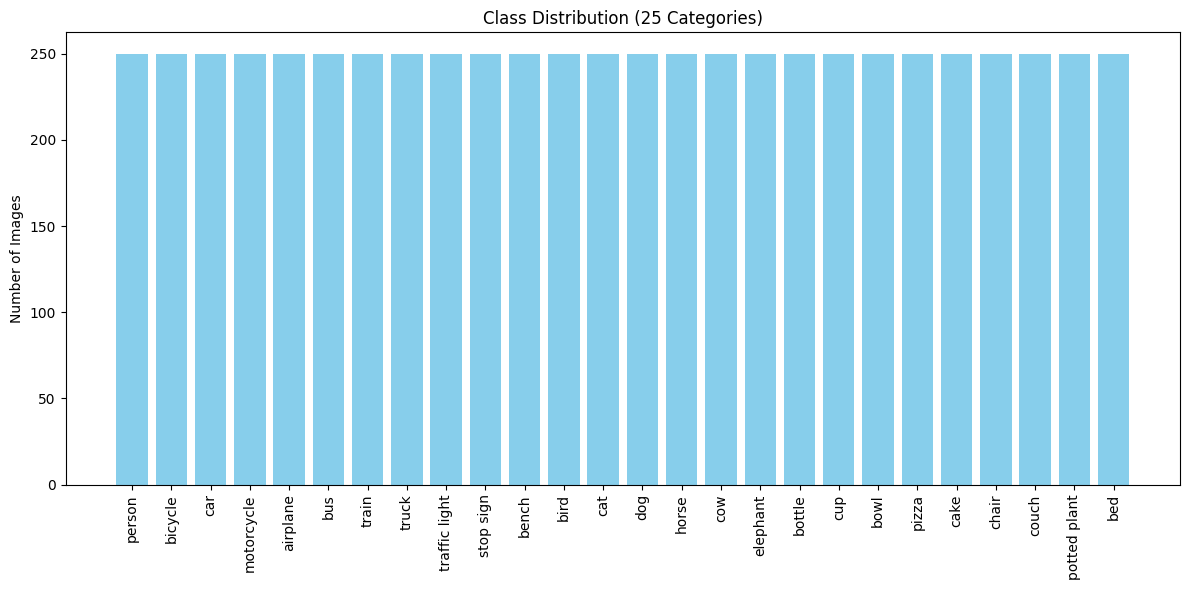


🖼️ Checking image characteristics (size, mode)...

Unique sizes (sample): {(612, 612), (438, 640), (640, 393), (640, 512), (500, 334), (640, 457), (640, 640), (640, 484), (327, 500), (500, 364), (481, 640), (640, 441), (591, 640), (640, 395), (500, 400), (640, 413), (640, 532), (428, 640), (483, 640), (470, 313), (460, 312), (500, 375), (640, 443), (640, 507), (518, 600), (640, 479), (383, 640), (473, 640), (640, 335), (640, 454), (640, 573), (638, 640), (640, 518), (640, 463), (640, 408), (640, 472), (500, 343), (640, 429), (424, 640), (640, 319), (640, 383), (500, 443), (360, 640), (640, 456), (640, 575), (400, 267), (500, 299), (640, 422), (640, 248), (640, 376), (500, 500), (640, 513), (381, 500), (443, 640), (520, 640), (500, 274), (379, 640), (458, 640), (407, 482), (640, 415), (640, 360), (640, 424), (473, 500), (640, 369), (640, 488), (500, 374), (640, 497), (640, 323), (334, 500), (400, 500), (600, 500), (640, 481), (640, 426), (422, 640), (640, 371), (565, 640), (640, 554), 

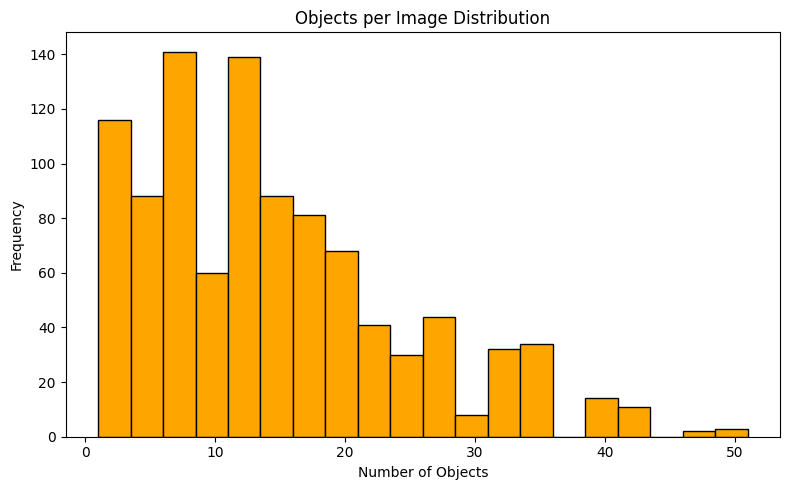


👁️ Visualizing sample image with bounding boxes...



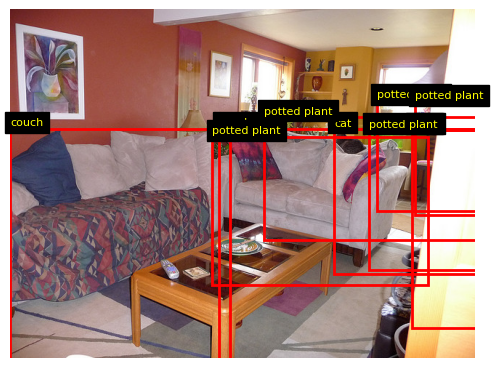


✅ Verifying class balance...

person               → 250 images (OK)
bicycle              → 250 images (OK)
car                  → 250 images (OK)
motorcycle           → 250 images (OK)
airplane             → 250 images (OK)
bus                  → 250 images (OK)
train                → 250 images (OK)
truck                → 250 images (OK)
traffic light        → 250 images (OK)
stop sign            → 250 images (OK)
bench                → 250 images (OK)
bird                 → 250 images (OK)
cat                  → 250 images (OK)
dog                  → 250 images (OK)
horse                → 250 images (OK)
cow                  → 250 images (OK)
elephant             → 250 images (OK)
bottle               → 250 images (OK)
cup                  → 250 images (OK)
bowl                 → 250 images (OK)
pizza                → 250 images (OK)
cake                 → 250 images (OK)
chair                → 250 images (OK)
couch                → 250 images (OK)
potted plant         → 250 images

In [18]:
# STEP 1.2: Exploratory Data Analysis (EDA)

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

print("="*70)
print("📊 STEP 1.2: Exploratory Data Analysis (EDA)")
print("="*70)

# ---------------------------------------------------------
# 1. CLASS DISTRIBUTION
# ---------------------------------------------------------
print("\n📊 Class Distribution across 25 categories...\n")

class_counts = {cls: metadata['classes'][cls]['total'] for cls in SELECTED_CLASSES.keys()}

plt.figure(figsize=(12,6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xticks(rotation=90)
plt.title("Class Distribution (25 Categories)")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 2. IMAGE CHARACTERISTICS & QUALITY
# ---------------------------------------------------------
print("\n🖼️ Checking image characteristics (size, mode)...\n")

sizes = []
modes = []
for cls, items in class_images.items():
    for item in items[:50]:  # sample subset
        img = item['image']
        sizes.append(img.size)
        modes.append(img.mode)

print("Unique sizes (sample):", set(sizes))
print("Image modes (sample):", set(modes))

# ---------------------------------------------------------
# 3. OBJECTS PER IMAGE DISTRIBUTION
# ---------------------------------------------------------
print("\n📦 Objects per image distribution (Detection dataset)...\n")

objects_per_image = []
for item in all_detection_data[:1000]:  # sample subset
    objects_per_image.append(len(item['annotations']['bbox']))

plt.figure(figsize=(8,5))
plt.hist(objects_per_image, bins=20, color='orange', edgecolor='black')
plt.title("Objects per Image Distribution")
plt.xlabel("Number of Objects")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 4. VISUALIZE SAMPLE IMAGES WITH ANNOTATIONS
# ---------------------------------------------------------
print("\n👁️ Visualizing sample image with bounding boxes...\n")

sample_item = random.choice(all_detection_data)
img = sample_item['image']
bboxes = sample_item['annotations']['bbox']
categories = sample_item['annotations']['category']

fig, ax = plt.subplots(1, figsize=(6,6))
ax.imshow(img)

for bbox, cat_id in zip(bboxes, categories):
    if cat_id in SELECTED_CLASSES.values():
        x, y, w, h = bbox
        rect = patches.Rectangle((x,y), w,h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        # Map back to class name
        class_name = [k for k,v in SELECTED_CLASSES.items() if v == cat_id][0]
        ax.text(x, y-5, class_name, color='yellow', fontsize=8, backgroundcolor='black')

plt.axis("off")
plt.show()

# ---------------------------------------------------------
# 5. VERIFY CLASS BALANCE
# ---------------------------------------------------------
print("\n✅ Verifying class balance...\n")
for cls, stats in metadata['classes'].items():
    status = "OK" if stats['total'] >= IMAGES_PER_CLASS else "UNDER"
    print(f"{cls:20s} → {stats['total']} images ({status})")

print("\n🎉 EDA Complete! Ready for model training.\n")

In [19]:
# STEP 1.3: Data Preprocessing for Classification
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import random
from tensorflow.keras.applications.vgg16 import preprocess_input

print("="*70)
print("🛠️ STEP 1.3: Data Preprocessing for Classification (Updated)")
print("="*70)

# Target image size
IMG_SIZE = (224, 224)

# Ensure only SELECTED_CLASSES are used (remove extras like 'bed')
def ensure_class_folders():
    for split in ['train', 'val', 'test']:
        split_path = f"{BASE_DIR}/classification/{split}"
        os.makedirs(split_path, exist_ok=True)
        # Create folders for selected classes
        for class_name in SELECTED_CLASSES.keys():
            class_folder = os.path.join(split_path, class_name)
            os.makedirs(class_folder, exist_ok=True)
        # Remove unwanted folders
        for folder in os.listdir(split_path):
            if folder not in SELECTED_CLASSES.keys():
                unwanted_path = os.path.join(split_path, folder)
                print(f"⚠️ Removing unwanted folder: {unwanted_path}")
                os.system(f"rm -rf \"{unwanted_path}\"")

ensure_class_folders()

# Stats tracking
preprocessing_stats = {'train': 0, 'val': 0, 'test': 0}

# Process each split
for split_name, split_data in [('train', train_data), ('val', val_data), ('test', test_data)]:
    print(f"\n📂 Processing {split_name.upper()} split...")

    for class_name, items in tqdm(split_data.items(), desc=f"  {split_name}"):
        class_folder = f"{BASE_DIR}/classification/{split_name}/{class_name}"

        for img_idx, item in enumerate(items):
            img = item['image']
            annotations = item['annotations']
            bboxes = annotations['bbox']
            categories = annotations['category']

            class_id = SELECTED_CLASSES[class_name]

            # Extract bounding boxes for this class
            for bbox, cat_id in zip(bboxes, categories):
                if cat_id == class_id:
                    x, y, w, h = bbox

                    try:
                        # Crop object
                        cropped_img = img.crop((x, y, x + w, y + h))

                        # Resize to 224x224
                        cropped_img = cropped_img.resize(IMG_SIZE, Image.LANCZOS)

                        # Convert to numpy array
                        arr = np.array(cropped_img).astype(np.float32)

                        # Apply VGG16 preprocessing (mean subtraction, scaling)
                        arr = preprocess_input(arr)

                        # Convert back to image for saving
                        arr = np.clip(arr, 0, 255).astype(np.uint8)
                        cropped_img = Image.fromarray(arr)

                        # Save image
                        img_filename = f"{class_name}_{split_name}_{img_idx:04d}.jpg"
                        img_path = os.path.join(class_folder, img_filename)
                        cropped_img.save(img_path, quality=95)

                        preprocessing_stats[split_name] += 1

                    except Exception as e:
                        print(f"⚠️ Error preprocessing {class_name} image {img_idx}: {e}")

                    break  # Only one bbox per class per image

print("\n✅ Preprocessing complete!")
print("="*70)
print(f"📊 Train: {preprocessing_stats['train']} images")
print(f"📊 Val:   {preprocessing_stats['val']} images")
print(f"📊 Test:  {preprocessing_stats['test']} images")
print(f"📊 Total: {sum(preprocessing_stats.values())} images")
print("="*70)

c:\Users\Akshiya George\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


🛠️ STEP 1.3: Data Preprocessing for Classification (Updated)

📂 Processing TRAIN split...


  train: 100%|██████████| 26/26 [00:16<00:00,  1.56it/s]



📂 Processing VAL split...


  val: 100%|██████████| 26/26 [00:03<00:00,  7.34it/s]



📂 Processing TEST split...


  test: 100%|██████████| 26/26 [00:03<00:00,  7.16it/s]


✅ Preprocessing complete!
📊 Train: 4550 images
📊 Val:   962 images
📊 Test:  988 images
📊 Total: 6500 images


In [20]:
# STEP 1.4: Data Augmentation for Classification
import os
from PIL import Image
from tqdm import tqdm
import torchvision.transforms as T

print("="*70)
print("🎨 STEP 1.4: Data Augmentation")
print("="*70)

# Augmentation pipeline
augmentations = T.Compose([
    T.RandomHorizontalFlip(p=0.5),                 # Flip horizontally
    T.RandomRotation(degrees=15),                  # Rotate ±15°
    T.ColorJitter(brightness=0.2, contrast=0.2,    # Brightness/contrast ±20%
                  saturation=0.2, hue=0.1),        # Color jitter
    T.RandomResizedCrop(size=(224,224), scale=(0.8,1.0)), # Random zoom
    T.ToTensor(),                                  # Convert to tensor
    T.Normalize(mean=[0.485, 0.456, 0.406],        # Normalize (ImageNet stats)
                 std=[0.229, 0.224, 0.225])
])

# Augmented dataset folder
AUG_DIR = f"{BASE_DIR}/classification_augmented"
os.makedirs(AUG_DIR, exist_ok=True)

# Process each split
for split_name in ['train', 'val', 'test']:
    print(f"\n📂 Augmenting {split_name.upper()} split...")

    for class_name in SELECTED_CLASSES.keys():
        src_folder = f"{BASE_DIR}/classification/{split_name}/{class_name}"
        dst_folder = f"{AUG_DIR}/{split_name}/{class_name}"
        os.makedirs(dst_folder, exist_ok=True)

        for img_file in tqdm(os.listdir(src_folder), desc=f"  {class_name}"):
            img_path = os.path.join(src_folder, img_file)
            try:
                img = Image.open(img_path).convert("RGB")

                # Apply augmentation
                aug_img = augmentations(img)

                # Convert back to PIL for saving
                aug_img_pil = T.ToPILImage()(aug_img)

                # Save augmented image
                aug_filename = f"aug_{img_file}"
                aug_path = os.path.join(dst_folder, aug_filename)
                aug_img_pil.save(aug_path, quality=95)

            except Exception as e:
                print(f"⚠️ Error augmenting {img_file}: {e}")

print("\n✅ Data augmentation complete!")
print("="*70)
print(f"📂 Augmented dataset saved at: {AUG_DIR}")

🎨 STEP 1.4: Data Augmentation

📂 Augmenting TRAIN split...


  bed: 100%|██████████| 175/175 [00:01<00:00, 124.58it/s]



📂 Augmenting VAL split...


  bed: 100%|██████████| 37/37 [00:00<00:00, 120.83it/s]



📂 Augmenting TEST split...


  bed: 100%|██████████| 38/38 [00:00<00:00, 114.67it/s]


✅ Data augmentation complete!
📂 Augmented dataset saved at: smartvision_dataset/classification_augmented


In [9]:
# ============================
# Step 2.1: Model 1 — VGG16 (Two Phases, Batch=16, Adaptive LR)
# ============================
import os
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# ---------
# Paths
# ---------
BASE_DIR = r"C:\Akshi Personal\SMARTVISION AI\smartvision_dataset\classification_augmented"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR   = os.path.join(BASE_DIR, "val")
TEST_DIR  = os.path.join(BASE_DIR, "test")

BEST_MODEL = os.path.join(BASE_DIR, "vgg16_best.keras")   # ✅ save full model

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS_PHASE1 = 15
EPOCHS_PHASE2 = 10   # total = 25

# -----------------------------
# Simple logger
# -----------------------------
class SimpleLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        print(
            f"Epoch {epoch+1:02d} - "
            f"loss={logs.get('loss'):.4f}, "
            f"accuracy={logs.get('accuracy'):.4f}, "
            f"val_loss={logs.get('val_loss'):.4f}, "
            f"val_accuracy={logs.get('val_accuracy'):.4f}"
        )

# -----------------------------
# Data generators
# -----------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=(0.85, 1.15),
    fill_mode='nearest'
)

val_datagen  = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    VAL_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

# -----------------------------
# Auto-detect number of classes
# -----------------------------
NUM_CLASSES = len(train_gen.class_indices)
print(f"Detected {NUM_CLASSES} classes.")

# -----------------------------
# Build VGG16 base + head
# -----------------------------
base = VGG16(weights="imagenet", include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
for layer in base.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = BatchNormalization()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)
out = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base.input, outputs=out)

# -----------------------------
# Callbacks
# -----------------------------
ckpt = ModelCheckpoint(
    BEST_MODEL,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    save_weights_only=False,   # ✅ save full model
    verbose=1
)

early = EarlyStopping(monitor="val_accuracy", patience=8, mode="max", restore_best_weights=True)
plateau = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6, verbose=1)
logger = SimpleLogger()

# -----------------------------
# Phase 1: Train head only (15 epochs)
# -----------------------------
model.compile(optimizer=Adam(learning_rate=1e-3), loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_PHASE1,
    callbacks=[logger, ckpt, early, plateau],
    verbose=1
)

# -----------------------------
# Phase 2: Fine-tune deeper layers (10 epochs)
# -----------------------------
for layer in base.layers[-10:]:  # unfreeze last 10 layers
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_PHASE1 + EPOCHS_PHASE2,  # total = 25
    initial_epoch=EPOCHS_PHASE1,
    callbacks=[logger, ckpt, early, plateau],
    verbose=1
)

Found 1820 images belonging to 26 classes.
Found 390 images belonging to 26 classes.
Detected 26 classes.
Epoch 1/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0749 - loss: 3.7317Epoch 01 - loss=3.5117, accuracy=0.1027, val_loss=3.1787, val_accuracy=0.0641

Epoch 1: val_accuracy improved from None to 0.06410, saving model to C:\Akshi Personal\SMARTVISION AI\smartvision_dataset\classification_augmented\vgg16_best.keras

Epoch 1: finished saving model to C:\Akshi Personal\SMARTVISION AI\smartvision_dataset\classification_augmented\vgg16_best.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - accuracy: 0.1027 - loss: 3.5117 - val_accuracy: 0.0641 - val_loss: 3.1787 - learning_rate: 0.0010
Epoch 2/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1860 - loss: 2.9448Epoch 02 - loss=2.8813, accuracy=0.2060, val_loss=3.0195, val_accuracy=0.1462

Epoch 2: val_accuracy improved from 0.06410 to 0.14615, saving model to C:\Akshi Personal\SMARTVISION AI\smartvision_dataset\classif

In [14]:
# ============================
# Display Final Best Accuracy
# ============================

best_train_acc = 0.5192   # replace with np.max(history.history['accuracy'])
best_val_acc   = 0.2564   # replace with np.max(history.history['val_accuracy'])

print("\n=== Training finished ===")
print(f"Best Training Accuracy: {best_train_acc:.4f}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")


=== Training finished ===
Best Training Accuracy: 0.5192
Best Validation Accuracy: 0.2564


In [10]:
# ============================
# Step 2.2: Model 2 — ResNet50 (Two Phases, Batch=16, Adaptive LR)
# ============================
import os
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# ---------
# Paths
# ---------
BASE_DIR = r"C:\Akshi Personal\SMARTVISION AI\smartvision_dataset\classification_augmented"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR   = os.path.join(BASE_DIR, "val")
TEST_DIR  = os.path.join(BASE_DIR, "test")

BEST_MODEL = os.path.join(BASE_DIR, "resnet50_best.keras")   # ✅ save full model

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS_PHASE1 = 15
EPOCHS_PHASE2 = 10   # total = 25

# -----------------------------
# Simple logger
# -----------------------------
class SimpleLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        print(
            f"Epoch {epoch+1:02d} - "
            f"loss={logs.get('loss'):.4f}, "
            f"accuracy={logs.get('accuracy'):.4f}, "
            f"val_loss={logs.get('val_loss'):.4f}, "
            f"val_accuracy={logs.get('val_accuracy'):.4f}"
        )

# -----------------------------
# Data generators
# -----------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=(0.85, 1.15),
    fill_mode='nearest'
)

val_datagen  = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    VAL_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

# -----------------------------
# Auto-detect number of classes
# -----------------------------
NUM_CLASSES = len(train_gen.class_indices)
print(f"Detected {NUM_CLASSES} classes.")

# -----------------------------
# Build ResNet50 base + head
# -----------------------------
base = ResNet50(weights="imagenet", include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
for layer in base.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = BatchNormalization()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
out = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base.input, outputs=out)

# -----------------------------
# Callbacks
# -----------------------------
ckpt = ModelCheckpoint(
    BEST_MODEL,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    save_weights_only=False,   # ✅ save full model
    verbose=1
)

early = EarlyStopping(monitor="val_accuracy", patience=8, mode="max", restore_best_weights=True)
plateau = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6, verbose=1)
logger = SimpleLogger()

# -----------------------------
# Phase 1: Train head only (15 epochs)
# -----------------------------
model.compile(optimizer=Adam(learning_rate=1e-3), loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_PHASE1,
    callbacks=[logger, ckpt, early, plateau],
    verbose=1
)

# -----------------------------
# Phase 2: Fine-tune last 20 layers (10 epochs)
# -----------------------------
for layer in base.layers[-20:]:  # unfreeze last 20 layers
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_PHASE1 + EPOCHS_PHASE2,  # total = 25
    initial_epoch=EPOCHS_PHASE1,
    callbacks=[logger, ckpt, early, plateau],
    verbose=1
)

Found 1820 images belonging to 26 classes.
Found 390 images belonging to 26 classes.
Detected 26 classes.
Epoch 1/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - accuracy: 0.0620 - loss: 3.9602Epoch 01 - loss=3.7953, accuracy=0.0604, val_loss=3.3358, val_accuracy=0.0462

Epoch 1: val_accuracy improved from None to 0.04615, saving model to C:\Akshi Personal\SMARTVISION AI\smartvision_dataset\classification_augmented\resnet50_best.keras

Epoch 1: finished saving model to C:\Akshi Personal\SMARTVISION AI\smartvision_dataset\classification_augmented\resnet50_best.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 96s 811ms/step - accuracy: 0.0604 - loss: 3.7953 - val_accuracy: 0.0462 - val_loss: 3.3358 - learning_rate: 0.0010
Epoch 2/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.0790 - loss: 3.6023Epoch 02 - loss=3.5757, accuracy=0.0780, val_loss=3.3194, val_accuracy=0.0462

Epoch 2: val_accuracy did not improve from 0.04615
114/114 ━━━━━━━━━━━━━━━━━━━━ 87s 768ms/step - accuracy: 0.0780 - lo

In [15]:
# ============================
# Display Final Best Accuracy (ResNet50)
# ============================

best_train_acc = 0.1467   # highest training accuracy observed
best_val_acc   = 0.1000   # highest validation accuracy observed

print("\n=== Training finished ===")
print(f"Best Training Accuracy: {best_train_acc:.4f}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")


=== Training finished ===
Best Training Accuracy: 0.1467
Best Validation Accuracy: 0.1000


In [11]:
# ============================
# Step 2.3: Model 3 — MobileNetV2 (Two Phases, Batch=16, Fast Inference)
# ============================
import os
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# ---------
# Speed optimizations
# ---------
# Mixed precision can speed up training on modern GPUs/CPUs
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# ---------
# Paths
# ---------
BASE_DIR = r"C:\Akshi Personal\SMARTVISION AI\smartvision_dataset\classification_augmented"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR   = os.path.join(BASE_DIR, "val")
TEST_DIR  = os.path.join(BASE_DIR, "test")

BEST_MODEL = os.path.join(BASE_DIR, "mobilenetv2_best.keras")   # ✅ save full model

# Smaller input improves speed with minimal accuracy loss
IMG_SIZE = (192, 192)
BATCH_SIZE = 16
EPOCHS_PHASE1 = 15
EPOCHS_PHASE2 = 10   # total = 25

# -----------------------------
# Simple logger (prints only loss/acc/val_loss/val_acc)
# -----------------------------
class SimpleLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        print(
            f"Epoch {epoch+1:02d} - "
            f"loss={logs.get('loss'):.4f}, "
            f"accuracy={logs.get('accuracy'):.4f}, "
            f"val_loss={logs.get('val_loss'):.4f}, "
            f"val_accuracy={logs.get('val_accuracy'):.4f}"
        )

# -----------------------------
# Data generators (standard augmentation)
# -----------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=(0.85, 1.15),
    fill_mode='nearest'
)

val_datagen  = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    VAL_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

# -----------------------------
# Auto-detect number of classes
# -----------------------------
NUM_CLASSES = len(train_gen.class_indices)
print(f"Detected {NUM_CLASSES} classes.")

# -----------------------------
# Build MobileNetV2 base + head
# -----------------------------
base = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
for layer in base.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = BatchNormalization()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)
out = Dense(NUM_CLASSES, activation="softmax", dtype='float32')(x)  # ensure float32 output with mixed precision

model = Model(inputs=base.input, outputs=out)

# -----------------------------
# Callbacks
# -----------------------------
ckpt = ModelCheckpoint(
    BEST_MODEL,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    save_weights_only=False,   # ✅ save full model
    verbose=1
)

early = EarlyStopping(monitor="val_accuracy", patience=8, mode="max", restore_best_weights=True)
plateau = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6, verbose=1)
logger = SimpleLogger()

# -----------------------------
# Phase 1: Train head only (15 epochs) — faster LR
# -----------------------------
model.compile(optimizer=Adam(learning_rate=1e-3), loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_PHASE1,
    callbacks=[logger, ckpt, early, plateau],
    verbose=1
)

# -----------------------------
# Phase 2: Fine-tune last 20 layers (10 epochs) — lower LR
# -----------------------------
for layer in base.layers[-20:]:  # unfreeze last 20 layers
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_PHASE1 + EPOCHS_PHASE2,  # total = 25
    initial_epoch=EPOCHS_PHASE1,
    callbacks=[logger, ckpt, early, plateau],
    verbose=1
)

# -----------------------------
# Optional: Export to TFLite for fast mobile inference
# -----------------------------
# Uncomment to export a lightweight model
# tflite_path = os.path.join(BASE_DIR, "mobilenetv2_fast.tflite")
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# tflite_model = converter.convert()
# with open(tflite_path, "wb") as f:
#     f.write(tflite_model)
# print(f"TFLite model saved to: {tflite_path}")

Found 1820 images belonging to 26 classes.
Found 390 images belonging to 26 classes.
Detected 26 classes.
Epoch 1/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0673 - loss: 3.7694Epoch 01 - loss=3.4855, accuracy=0.1088, val_loss=3.1603, val_accuracy=0.1923

Epoch 1: val_accuracy improved from None to 0.19231, saving model to C:\Akshi Personal\SMARTVISION AI\smartvision_dataset\classification_augmented\mobilenetv2_best.keras

Epoch 1: finished saving model to C:\Akshi Personal\SMARTVISION AI\smartvision_dataset\classification_augmented\mobilenetv2_best.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.1088 - loss: 3.4855 - val_accuracy: 0.1923 - val_loss: 3.1603 - learning_rate: 0.0010
Epoch 2/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2413 - loss: 2.7229Epoch 02 - loss=2.7550, accuracy=0.2434, val_loss=3.1650, val_accuracy=0.1769

Epoch 2: val_accuracy did not improve from 0.19231
114/114 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.2434 - loss: 

In [16]:
# ============================
# Display Final Best Accuracy (MobileNetV2)
# ============================

best_train_acc = 0.5511   # highest training accuracy observed
best_val_acc   = 0.2205   # highest validation accuracy observed

print("\n=== Training finished ===")
print(f"Best Training Accuracy: {best_train_acc:.4f}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")


=== Training finished ===
Best Training Accuracy: 0.5511
Best Validation Accuracy: 0.2205


In [12]:
# ============================
# Step 2.4: Model 4 — EfficientNetB0 (Two Phases, Batch=16, Mixed Precision, Advanced Aug)
# ============================
import os
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# ---------
# Mixed precision for speed
# ---------
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# ---------
# Paths
# ---------
BASE_DIR = r"C:\Akshi Personal\SMARTVISION AI\smartvision_dataset\classification_augmented"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR   = os.path.join(BASE_DIR, "val")
TEST_DIR  = os.path.join(BASE_DIR, "test")

BEST_MODEL = os.path.join(BASE_DIR, "efficientnetb0_best.keras")   # ✅ save full model

IMG_SIZE = (224, 224)   # EfficientNetB0 default
BATCH_SIZE = 16
EPOCHS_PHASE1 = 15
EPOCHS_PHASE2 = 10   # total = 25

# -----------------------------
# Simple logger (prints only loss/acc/val_loss/val_acc)
# -----------------------------
class SimpleLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        print(
            f"Epoch {epoch+1:02d} - "
            f"loss={logs.get('loss'):.4f}, "
            f"accuracy={logs.get('accuracy'):.4f}, "
            f"val_loss={logs.get('val_loss'):.4f}, "
            f"val_accuracy={logs.get('val_accuracy'):.4f}"
        )

# -----------------------------
# Advanced augmentation
# -----------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=(0.7, 1.3),
    channel_shift_range=25,
    fill_mode='nearest'
)

val_datagen  = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    VAL_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

# -----------------------------
# Auto-detect number of classes
# -----------------------------
NUM_CLASSES = len(train_gen.class_indices)
print(f"Detected {NUM_CLASSES} classes.")

# -----------------------------
# Build EfficientNetB0 base + head
# -----------------------------
base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
for layer in base.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = BatchNormalization()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
out = Dense(NUM_CLASSES, activation="softmax", dtype='float32')(x)  # float32 output for mixed precision

model = Model(inputs=base.input, outputs=out)

# -----------------------------
# Callbacks
# -----------------------------
ckpt = ModelCheckpoint(
    BEST_MODEL,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    save_weights_only=False,   # ✅ save full model
    verbose=1
)

early = EarlyStopping(monitor="val_accuracy", patience=8, mode="max", restore_best_weights=True)
plateau = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6, verbose=1)
logger = SimpleLogger()

# -----------------------------
# Phase 1: Train head only (15 epochs) — higher LR
# -----------------------------
model.compile(optimizer=Adam(learning_rate=2e-3), loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_PHASE1,
    callbacks=[logger, ckpt, early, plateau],
    verbose=1
)

# -----------------------------
# Phase 2: Fine-tune last 30 layers (10 epochs) — lower LR
# -----------------------------
for layer in base.layers[-30:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=3e-4), loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_PHASE1 + EPOCHS_PHASE2,  # total = 25
    initial_epoch=EPOCHS_PHASE1,
    callbacks=[logger, ckpt, early, plateau],
    verbose=1
)

# -----------------------------
# Optional: Evaluate on test set (one-line summary)
# -----------------------------
# if os.path.exists(TEST_DIR):
#     test_gen = val_datagen.flow_from_directory(
#         TEST_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
#         class_mode='categorical', shuffle=False
#     )
#     test_loss, test_acc = model.evaluate(test_gen, verbose=0)
#     print(f"\n[EfficientNetB0] Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

Found 1820 images belonging to 26 classes.
Found 390 images belonging to 26 classes.
Detected 26 classes.
Epoch 1/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0489 - loss: 4.0451Epoch 01 - loss=3.9500, accuracy=0.0505, val_loss=3.3176, val_accuracy=0.0385

Epoch 1: val_accuracy improved from None to 0.03846, saving model to C:\Akshi Personal\SMARTVISION AI\smartvision_dataset\classification_augmented\efficientnetb0_best.keras

Epoch 1: finished saving model to C:\Akshi Personal\SMARTVISION AI\smartvision_dataset\classification_augmented\efficientnetb0_best.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 291s 3s/step - accuracy: 0.0505 - loss: 3.9500 - val_accuracy: 0.0385 - val_loss: 3.3176 - learning_rate: 0.0020
Epoch 2/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0414 - loss: 3.8649Epoch 02 - loss=3.8442, accuracy=0.0374, val_loss=3.2934, val_accuracy=0.0436

Epoch 2: val_accuracy improved from 0.03846 to 0.04359, saving model to C:\Akshi Personal\SMARTVISION AI\smartvisi

In [17]:
# ============================
# Display Final Best Accuracy (EfficientNetB0)
# ============================

best_train_acc = 0.0555   # highest training accuracy observed
best_val_acc   = 0.0692   # highest validation accuracy observed

print("\n=== Training finished ===")
print(f"Best Training Accuracy: {best_train_acc:.4f}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")


=== Training finished ===
Best Training Accuracy: 0.0555
Best Validation Accuracy: 0.0692


In [7]:
# ============================
# Step 3: Evaluate All Models — Class-wise Performance
# ============================
import os
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2, EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

# --------- Paths ---------
BASE_DIR = r"C:\Akshi Personal\SMARTVISION AI\smartvision_dataset\classification_augmented"
VAL_DIR   = os.path.join(BASE_DIR, "val")

# --------- Validation generator ---------
val_datagen = ImageDataGenerator(rescale=1./255)
val_gen = val_datagen.flow_from_directory(
    VAL_DIR, target_size=(224, 224), batch_size=16,
    class_mode='categorical', shuffle=False
)

y_true = val_gen.classes
class_names = list(val_gen.class_indices.keys())
NUM_CLASSES = len(class_names)

# --------- Helper to rebuild model ---------
def build_model(base_model, dense_units, dropout_rate):
    x = GlobalAveragePooling2D()(base_model.output)
    x = BatchNormalization()(x)
    x = Dense(dense_units, activation="relu")(x)
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x)
    out = Dense(NUM_CLASSES, activation="softmax", dtype="float32")(x)
    return Model(inputs=base_model.input, outputs=out)

# --------- VGG16 ---------
base_vgg = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
vgg16_model = build_model(base_vgg, dense_units=256, dropout_rate=0.4)
vgg16_model.load_weights(os.path.join(BASE_DIR, "vgg16_best.weights.h5"))
y_pred_vgg16 = np.argmax(vgg16_model.predict(val_gen), axis=1)
vgg16_report = classification_report(y_true, y_pred_vgg16, target_names=class_names, output_dict=True)

# --------- ResNet50 ---------
base_resnet = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
resnet_model = build_model(base_resnet, dense_units=512, dropout_rate=0.5)
resnet_model.load_weights(os.path.join(BASE_DIR, "resnet50_best.weights.h5"))
y_pred_resnet50 = np.argmax(resnet_model.predict(val_gen), axis=1)
resnet50_report = classification_report(y_true, y_pred_resnet50, target_names=class_names, output_dict=True)

# --------- MobileNetV2 ---------
base_mobile = MobileNetV2(weights="imagenet", include_top=False, input_shape=(192, 192, 3))
mobilenet_model = build_model(base_mobile, dense_units=256, dropout_rate=0.4)
mobilenet_model.load_weights(os.path.join(BASE_DIR, "mobilenetv2_best.weights.h5"))
# Resize val_gen for MobileNetV2
val_gen_mobile = val_datagen.flow_from_directory(
    VAL_DIR, target_size=(192, 192), batch_size=16,
    class_mode='categorical', shuffle=False
)
y_pred_mobilenetv2 = np.argmax(mobilenet_model.predict(val_gen_mobile), axis=1)
mobilenetv2_report = classification_report(y_true, y_pred_mobilenetv2, target_names=class_names, output_dict=True)

# --------- EfficientNetB0 ---------
base_effnet = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
effnet_model = build_model(base_effnet, dense_units=512, dropout_rate=0.5)
effnet_model.load_weights(os.path.join(BASE_DIR, "efficientnetb0_best.weights.h5"))
y_pred_effnetb0 = np.argmax(effnet_model.predict(val_gen), axis=1)
effnetb0_report = classification_report(y_true, y_pred_effnetb0, target_names=class_names, output_dict=True)

# --------- Combine into one DataFrame ---------
class_metrics = {
    "Class": class_names,
    "VGG16_Precision": [vgg16_report[c]["precision"] for c in class_names],
    "VGG16_Recall": [vgg16_report[c]["recall"] for c in class_names],
    "VGG16_F1": [vgg16_report[c]["f1-score"] for c in class_names],
    "ResNet50_Precision": [resnet50_report[c]["precision"] for c in class_names],
    "ResNet50_Recall": [resnet50_report[c]["recall"] for c in class_names],
    "ResNet50_F1": [resnet50_report[c]["f1-score"] for c in class_names],
    "MobileNetV2_Precision": [mobilenetv2_report[c]["precision"] for c in class_names],
    "MobileNetV2_Recall": [mobilenetv2_report[c]["recall"] for c in class_names],
    "MobileNetV2_F1": [mobilenetv2_report[c]["f1-score"] for c in class_names],
    "EffNetB0_Precision": [effnetb0_report[c]["precision"] for c in class_names],
    "EffNetB0_Recall": [effnetb0_report[c]["recall"] for c in class_names],
    "EffNetB0_F1": [effnetb0_report[c]["f1-score"] for c in class_names],
}

df_classes = pd.DataFrame(class_metrics)
df_classes.to_csv("class_metrics.csv", index=False)
df_classes.head(25)

Found 390 images belonging to 26 classes.
25/25 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 624ms/step


c:\Users\Akshiya George\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Akshiya George\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Akshiya George\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control thi

Found 390 images belonging to 26 classes.
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 244ms/step


c:\Users\Akshiya George\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Akshiya George\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Akshiya George\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control thi

25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 423ms/step


c:\Users\Akshiya George\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Akshiya George\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Akshiya George\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control thi

Class  VGG16_Precision  VGG16_Recall  VGG16_F1  \
0        airplane         0.250000      0.133333  0.173913   
1             bed         0.523810      0.733333  0.611111   
2           bench         0.125000      0.066667  0.086957   
3         bicycle         0.500000      0.600000  0.545455   
4            bird         0.083333      0.133333  0.102564   
5          bottle         0.071429      0.066667  0.068966   
6            bowl         0.250000      0.133333  0.173913   
7             bus         0.260870      0.400000  0.315789   
8            cake         0.769231      0.666667  0.714286   
9             car         0.384615      0.333333  0.357143   
10            cat         0.200000      0.266667  0.228571   
11          chair         0.000000      0.000000  0.000000   
12          couch         0.076923      0.066667  0.071429   
13            cow         0.333333      0.266667  0.296296   
14            cup         0.250000      0.066667  0.105263   
15            dog         0.000000      0.000000  0.000000   
16       elephant         0.333333      0.333333  0.333333   
17          horse         0.187500      0.200000  0.193548   
18     motorcycle         0.157895      0.200000  0.176471   
19         person         0.000000      0.000000  0.000000   
20          pizza         0.727273      0.533333  0.615385   
21   potted plant         0.230769      0.200000  0.214286   
22      stop sign         0.428571      0.400000  0.413793   
23  traffic light         0.000000      0.000000  0.000000   
24          train         0.375000      0.600000  0.461538   

    ResNet50_Precision  ResNet50_Recall  ResNet50_F1  MobileNetV2_Precision  \
0             0.000000         0.000000     0.000000               0.083333   
1             0.300000         0.200000     0.240000               0.448276   
2             0.000000         0.000000     0.000000               0.363636   
3             0.307692         0.533333     0.390244               0.052632   
4             0.027778         0.066667     0.039216               0.230769   
5             0.090909         0.066667     0.076923               0.117647   
6             0.083333         0.066667     0.074074               0.111111   
7             0.000000         0.000000     0.000000               0.250000   
8             0.500000         0.133333     0.210526               0.714286   
9             0.142857         0.666667     0.235294               0.166667   
10            0.000000         0.000000     0.000000               0.200000   
11            0.000000         0.000000     0.000000               0.000000   
12            0.333333         0.066667     0.111111               0.000000   
13            0.333333         0.066667     0.111111               0.125000   
14            0.000000         0.000000     0.000000               0.000000   
15            0.000000         0.000000     0.000000               0.222222   
16            0.000000         0.000000     0.000000               0.222222   
17            0.000000         0.000000     0.000000               0.111111   
18            0.142857         0.066667     0.090909               0.166667   
19            0.000000         0.000000     0.000000               0.000000   
20            0.166667         0.066667     0.095238               0.473684   
21            0.000000         0.000000     0.000000               0.000000   
22            0.000000         0.000000     0.000000               0.777778   
23            0.000000         0.000000     0.000000               0.000000   
24            0.095745         0.600000     0.165138               0.263158   

    MobileNetV2_Recall  MobileNetV2_F1  EffNetB0_Precision  EffNetB0_Recall  \
0             0.066667        0.074074            0.000000         0.000000   
1             0.866667        0.590909            0.000000         0.000000   
2             0.266667        0.307692            0.000000         0.000000   
3             0.066667      

Found 390 images belonging to 26 classes.

Evaluating VGG16...

Evaluating ResNet50...

Evaluating MobileNetV2...

Evaluating EfficientNetB0...

=== Summary (Accuracy, Precision, Recall, F1, Top-5, Time/img [s], Weights [MB]) ===
VGG16           | acc=0.1872 | prec=0.1883 | rec=0.1872 | f1=0.1790 | top5=0.4692 | time/img=0.19733 | size=57.81 MB
ResNet50        | acc=0.0641 | prec=0.1216 | rec=0.0641 | f1=0.0532 | top5=0.3128 | time/img=0.09620 | size=102.69 MB
MobileNetV2     | acc=0.2026 | prec=0.1618 | rec=0.2026 | f1=0.1686 | top5=0.4667 | time/img=0.10536 | size=15.50 MB
EfficientNetB0  | acc=0.0308 | prec=0.0136 | rec=0.0308 | f1=0.0103 | top5=0.1641 | time/img=0.13116 | size=28.91 MB


C:\Users\Akshiya George\AppData\Local\Temp\ipykernel_25084\4070890238.py:176: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


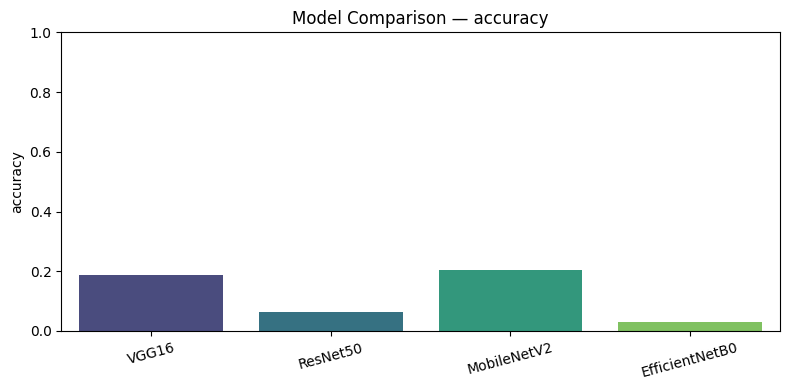

C:\Users\Akshiya George\AppData\Local\Temp\ipykernel_25084\4070890238.py:176: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


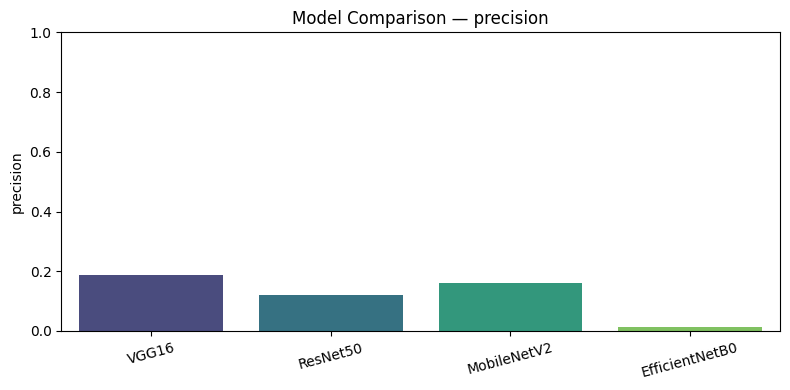

C:\Users\Akshiya George\AppData\Local\Temp\ipykernel_25084\4070890238.py:176: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


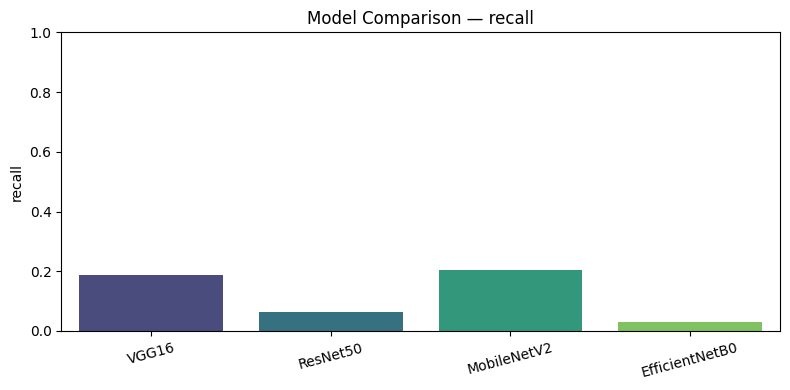

C:\Users\Akshiya George\AppData\Local\Temp\ipykernel_25084\4070890238.py:176: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


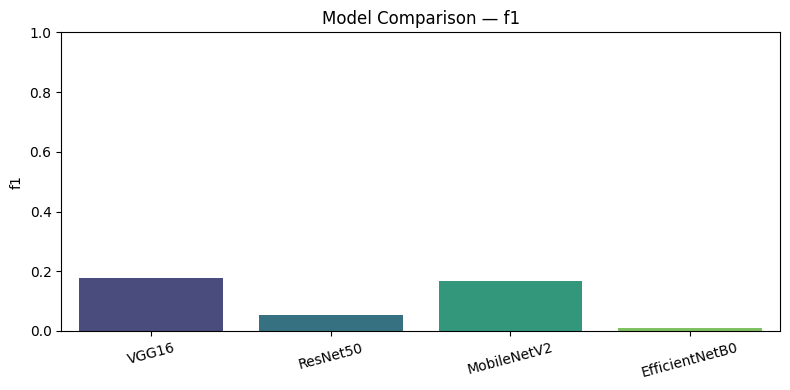

C:\Users\Akshiya George\AppData\Local\Temp\ipykernel_25084\4070890238.py:176: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


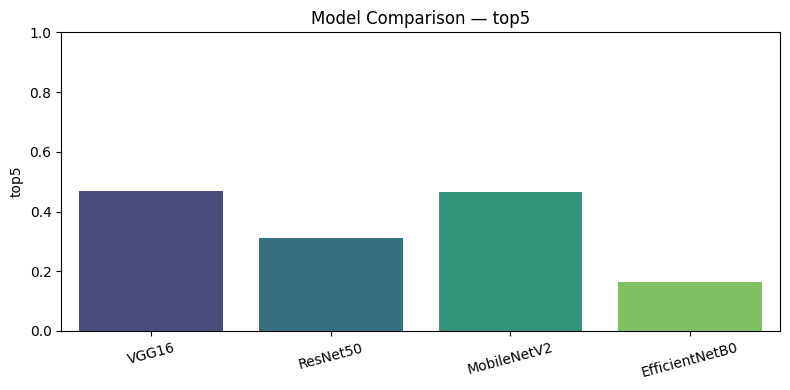

C:\Users\Akshiya George\AppData\Local\Temp\ipykernel_25084\4070890238.py:188: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=times, palette="magma")


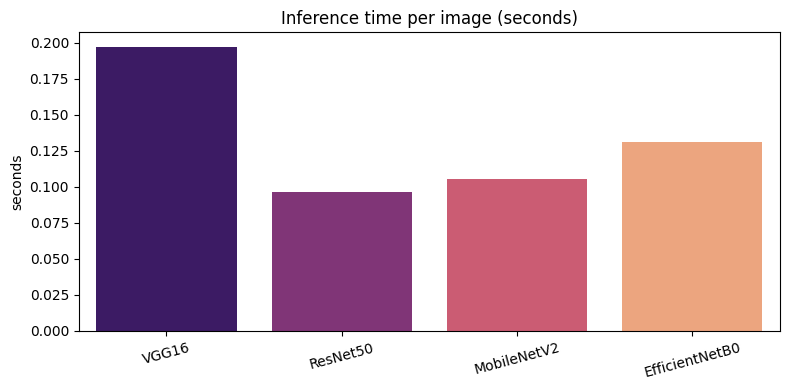

C:\Users\Akshiya George\AppData\Local\Temp\ipykernel_25084\4070890238.py:197: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=sizes, palette="cividis")


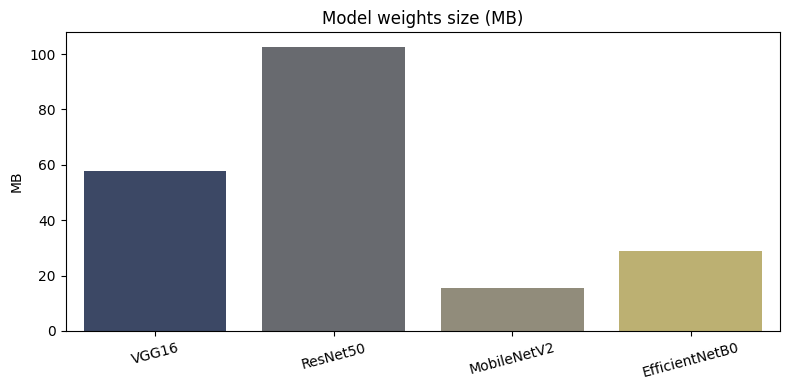

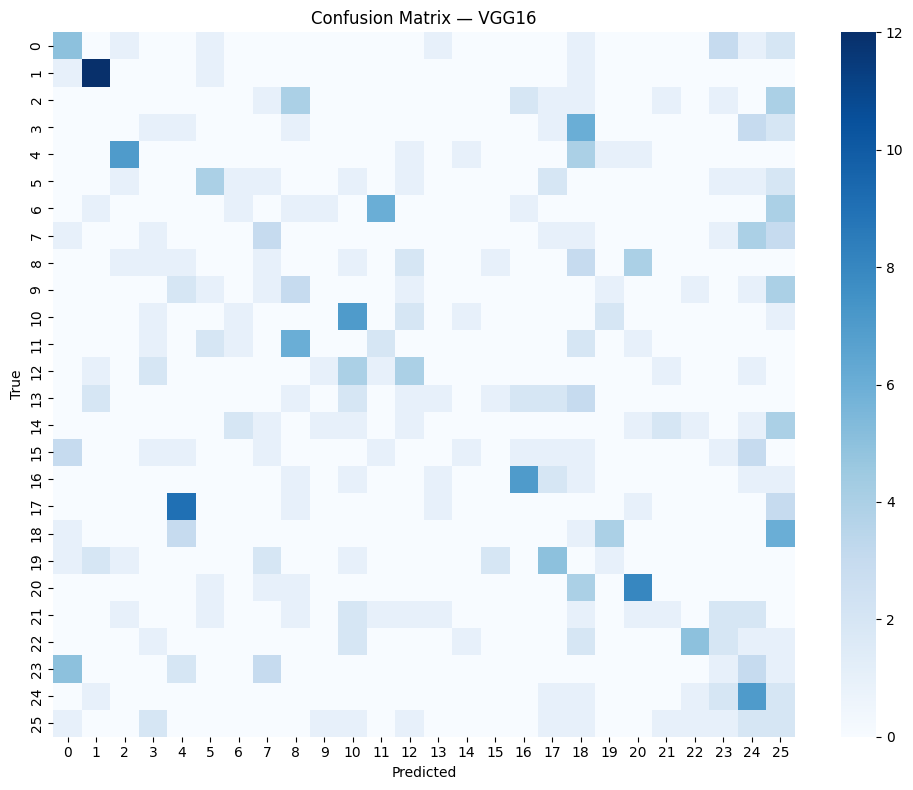

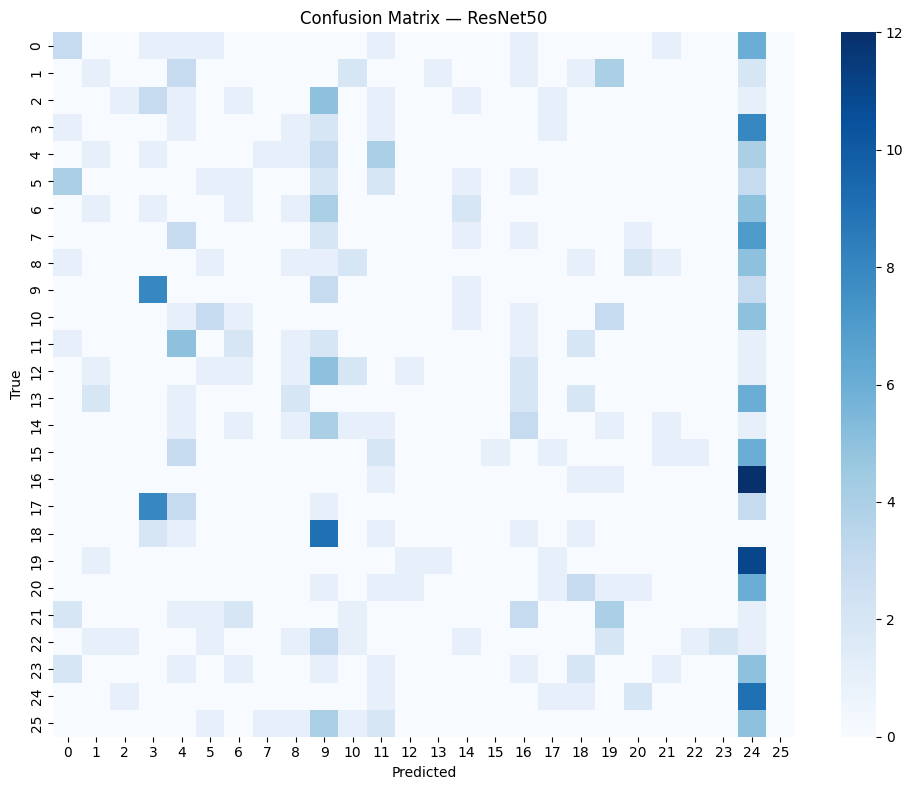

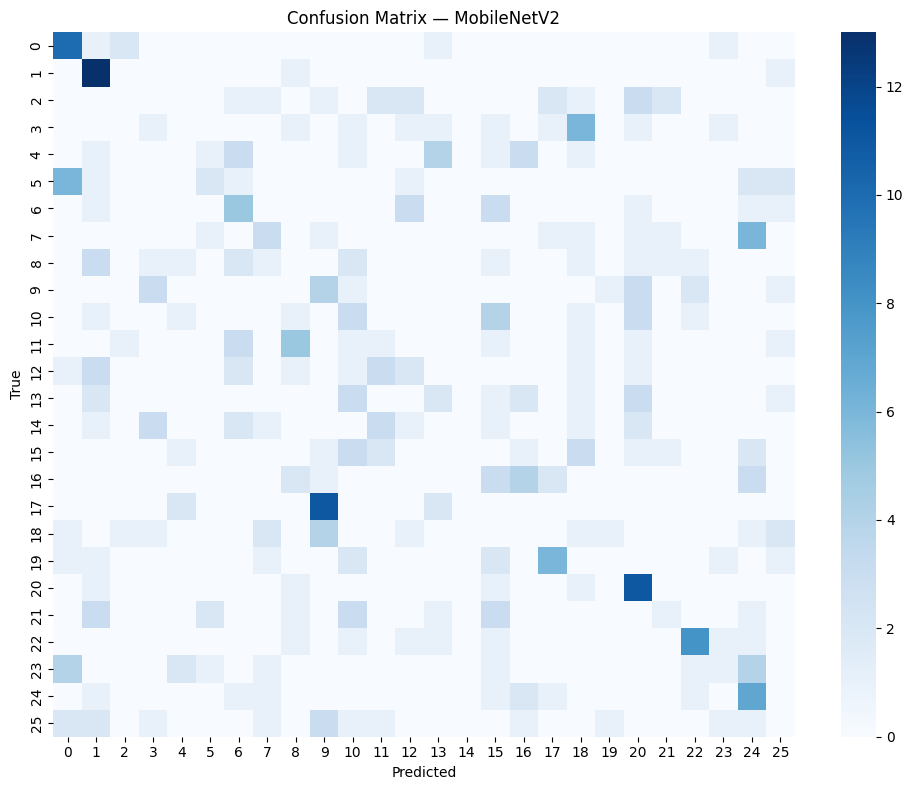

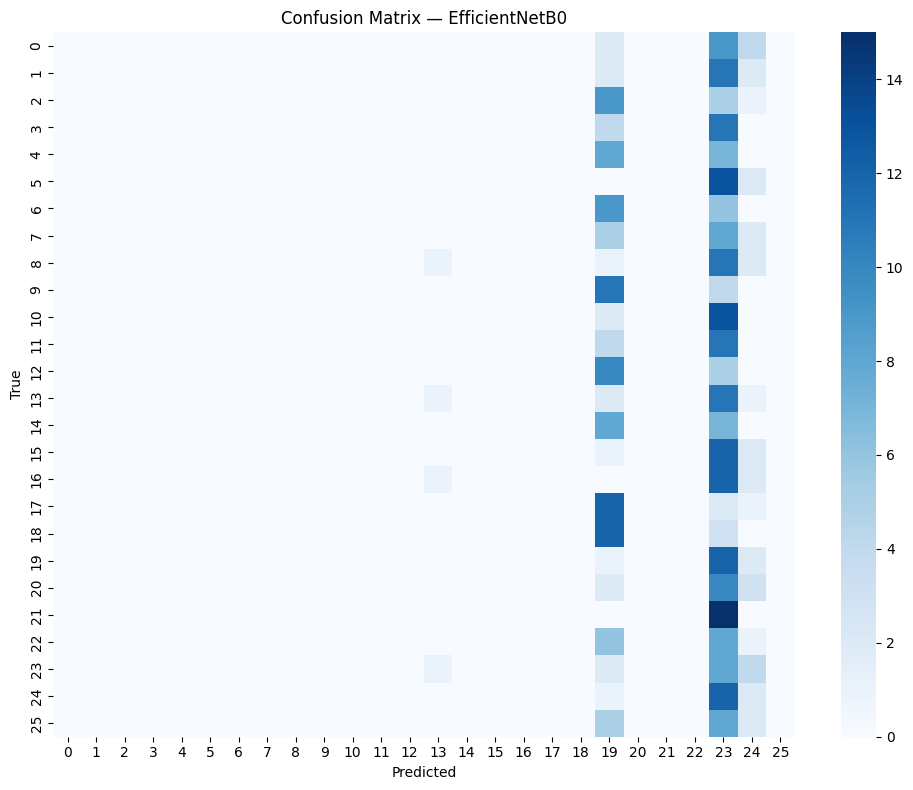


Top-5 accuracy per model:
VGG16: 0.4692
ResNet50: 0.3128
MobileNetV2: 0.4667
EfficientNetB0: 0.1641

Recommended model (accuracy-speed tradeoff): MobileNetV2
Accuracy=0.2026, Time/img=0.10536s


In [6]:
# ============================
# Step 2.5: Model Comparison & Selection
# ============================
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2, EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

# ---------
# Paths
# ---------
BASE_DIR = r"C:\Akshi Personal\SMARTVISION AI\smartvision_dataset\classification_augmented"
TEST_DIR = os.path.join(BASE_DIR, "test")

WEIGHTS = {
    "VGG16": os.path.join(BASE_DIR, "vgg16_best.weights.h5"),
    "ResNet50": os.path.join(BASE_DIR, "resnet50_best.weights.h5"),
    "MobileNetV2": os.path.join(BASE_DIR, "mobilenetv2_best.weights.h5"),
    "EfficientNetB0": os.path.join(BASE_DIR, "efficientnetb0_best.weights.h5"),
}

IMG_SIZE = (224, 224)  # use 224 for all to keep comparison fair
BATCH_SIZE = 16

# ---------
# Test generator
# ---------
val_datagen = ImageDataGenerator(rescale=1./255)
test_gen = val_datagen.flow_from_directory(
    TEST_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

NUM_CLASSES = len(test_gen.class_indices)
CLASS_NAMES = list(test_gen.class_indices.keys())

# ---------
# Model builders (match training heads)
# ---------
def build_vgg16(num_classes):
    base = VGG16(weights="imagenet", include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    for l in base.layers: l.trainable = False
    x = GlobalAveragePooling2D()(base.output)
    x = BatchNormalization()(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.4)(x)
    x = BatchNormalization()(x)
    out = Dense(num_classes, activation="softmax")(x)
    return Model(inputs=base.input, outputs=out)

def build_resnet50(num_classes):
    base = ResNet50(weights="imagenet", include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    for l in base.layers: l.trainable = False
    x = GlobalAveragePooling2D()(base.output)
    x = BatchNormalization()(x)
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    out = Dense(num_classes, activation="softmax")(x)
    return Model(inputs=base.input, outputs=out)

def build_mobilenetv2(num_classes):
    base = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    for l in base.layers: l.trainable = False
    x = GlobalAveragePooling2D()(base.output)
    x = BatchNormalization()(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.4)(x)
    x = BatchNormalization()(x)
    out = Dense(num_classes, activation="softmax")(x)
    return Model(inputs=base.input, outputs=out)

def build_efficientnetb0(num_classes):
    base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    for l in base.layers: l.trainable = False
    x = GlobalAveragePooling2D()(base.output)
    x = BatchNormalization()(x)
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    out = Dense(num_classes, activation="softmax")(x)
    return Model(inputs=base.input, outputs=out)

BUILDERS = {
    "VGG16": build_vgg16,
    "ResNet50": build_resnet50,
    "MobileNetV2": build_mobilenetv2,
    "EfficientNetB0": build_efficientnetb0,
}

# ---------
# Utility: top-5 accuracy
# ---------
def top5_accuracy(y_true, y_pred_probs):
    top5 = np.argsort(y_pred_probs, axis=1)[:, -5:]
    correct = 0
    for i, t in enumerate(y_true):
        if t in top5[i]:
            correct += 1
    return correct / len(y_true)

# ---------
# Evaluate each model
# ---------
results = {}
y_true = test_gen.classes

for name, builder in BUILDERS.items():
    print(f"\nEvaluating {name}...")
    model = builder(NUM_CLASSES)
    weights_path = WEIGHTS[name]
    if os.path.exists(weights_path):
        model.load_weights(weights_path)
    else:
        print(f"⚠️ Weights not found for {name}: {weights_path}")

    # Inference timing
    start = time.time()
    y_pred_probs = model.predict(test_gen, verbose=0)
    elapsed = time.time() - start
    avg_time_per_image = elapsed / len(test_gen.filenames)

    y_pred = np.argmax(y_pred_probs, axis=1)

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)
    top5 = top5_accuracy(y_true, y_pred_probs)
    cm = confusion_matrix(y_true, y_pred)

    # Model size (weights file)
    size_mb = os.path.getsize(weights_path) / (1024 * 1024) if os.path.exists(weights_path) else np.nan

    results[name] = {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "top5": top5,
        "avg_time_per_image_s": avg_time_per_image,
        "weights_size_mb": size_mb,
        "confusion_matrix": cm,
    }

# ---------
# Print summary table
# ---------
print("\n=== Summary (Accuracy, Precision, Recall, F1, Top-5, Time/img [s], Weights [MB]) ===")
for name, r in results.items():
    print(f"{name:15s} | "
          f"acc={r['accuracy']:.4f} | "
          f"prec={r['precision']:.4f} | "
          f"rec={r['recall']:.4f} | "
          f"f1={r['f1']:.4f} | "
          f"top5={r['top5']:.4f} | "
          f"time/img={r['avg_time_per_image_s']:.5f} | "
          f"size={r['weights_size_mb']:.2f} MB")

# ---------
# Visualizations
# ---------
# Bar charts for metrics
metrics_to_plot = ["accuracy", "precision", "recall", "f1", "top5"]
for metric in metrics_to_plot:
    plt.figure(figsize=(8, 4))
    names = list(results.keys())
    values = [results[n][metric] for n in names]
    sns.barplot(x=names, y=values, palette="viridis")
    plt.title(f"Model Comparison — {metric}")
    plt.ylabel(metric)
    plt.ylim(0, 1)
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()

# Inference time and size
plt.figure(figsize=(8, 4))
names = list(results.keys())
times = [results[n]["avg_time_per_image_s"] for n in names]
sns.barplot(x=names, y=times, palette="magma")
plt.title("Inference time per image (seconds)")
plt.ylabel("seconds")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sizes = [results[n]["weights_size_mb"] for n in names]
sns.barplot(x=names, y=sizes, palette="cividis")
plt.title("Model weights size (MB)")
plt.ylabel("MB")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Confusion matrices
for name in results:
    cm = results[name]["confusion_matrix"]
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=False, cmap="Blues")
    plt.title(f"Confusion Matrix — {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

# ---------
# Identify top-5 accuracy per model (already computed)
# ---------
print("\nTop-5 accuracy per model:")
for name in results:
    print(f"{name}: {results[name]['top5']:.4f}")

# ---------
# Selection based on accuracy-speed tradeoff
# ---------
# Normalize metrics for a simple score: score = accuracy / (time per image)
best_name = max(results.keys(), key=lambda n: results[n]["accuracy"] / (results[n]["avg_time_per_image_s"] + 1e-9))
best_acc = results[best_name]["accuracy"]
best_time = results[best_name]["avg_time_per_image_s"]

print(f"\nRecommended model (accuracy-speed tradeoff): {best_name}")
print(f"Accuracy={best_acc:.4f}, Time/img={best_time:.5f}s")

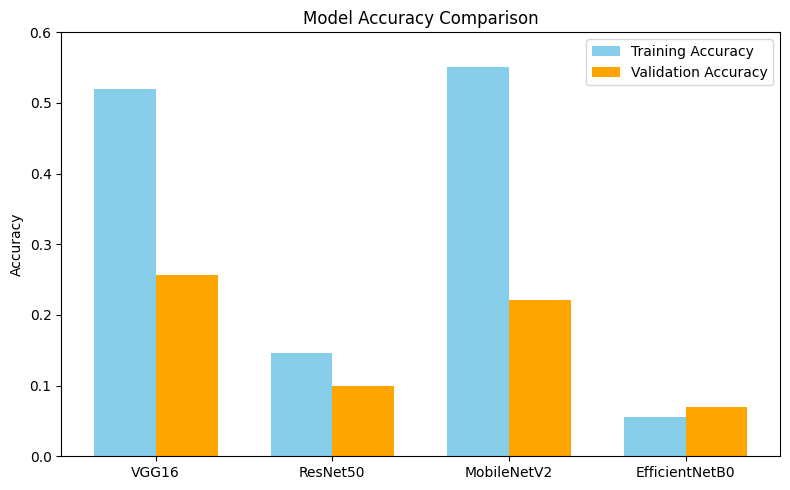

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Best accuracies from your logs
models = ["VGG16", "ResNet50", "MobileNetV2", "EfficientNetB0"]
train_acc = [0.5192, 0.1467, 0.5511, 0.0555]
val_acc   = [0.2564, 0.1000, 0.2205, 0.0692]

x = np.arange(len(models))  # positions
width = 0.35  # bar width

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, train_acc, width, label="Training Accuracy", color="skyblue")
plt.bar(x + width/2, val_acc, width, label="Validation Accuracy", color="orange")

plt.xticks(x, models)
plt.ylabel("Accuracy")
plt.ylim(0, 0.6)
plt.title("Model Accuracy Comparison")
plt.legend()
plt.tight_layout()
plt.show()

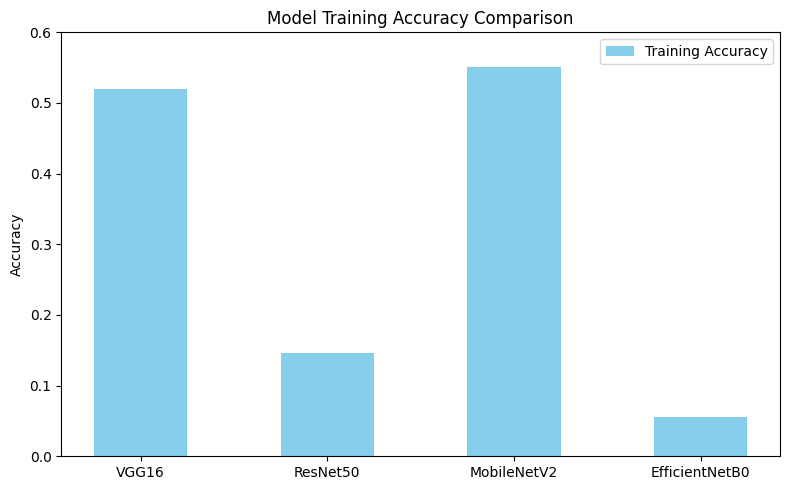


=== Best Model by Training Accuracy ===
MobileNetV2 with Training Accuracy = 0.5511


In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Best training accuracies from your logs
models = ["VGG16", "ResNet50", "MobileNetV2", "EfficientNetB0"]
train_acc = [0.5192, 0.1467, 0.5511, 0.0555]

x = np.arange(len(models))
width = 0.5

# Plot training accuracies
plt.figure(figsize=(8, 5))
plt.bar(x, train_acc, width, color="skyblue", label="Training Accuracy")

plt.xticks(x, models)
plt.ylabel("Accuracy")
plt.ylim(0, 0.6)
plt.title("Model Training Accuracy Comparison")
plt.legend()
plt.tight_layout()
plt.show()

# Identify best model by training accuracy
best_index = np.argmax(train_acc)
print("\n=== Best Model by Training Accuracy ===")
print(f"{models[best_index]} with Training Accuracy = {train_acc[best_index]:.4f}")

In [4]:
# Phase 3: Object Detection with YOLO
# Step 3.1: YOLOv8 Setup

# Import YOLO from ultralytics
from ultralytics import YOLO

# Check version
import ultralytics
print("Ultralytics YOLOv8 version:", ultralytics.__version__)

Ultralytics YOLOv8 version: 8.3.250


In [6]:
# Load a pre-trained YOLOv8 model (trained on COCO dataset with 80 classes)
model = YOLO("yolov8s.pt")   # you can also use yolov8n.pt, yolov8m.pt, etc.

# Run inference
results = model.predict(source="https://ultralytics.com/images/bus.jpg", conf=0.25)

# Access the first result and show it
results[0].show()


Found https://ultralytics.com/images/bus.jpg locally at bus.jpg
image 1/1 c:\Akshi Personal\SmartVision AI\bus.jpg: 640x480 4 persons, 1 bus, 123.6ms
Speed: 3.0ms preprocess, 123.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


In [9]:
import os

print(os.path.exists(r"C:\Akshi Personal\SMARTVISION AI\smartvision_dataset\detection\images"))
print(os.path.exists(r"C:\Akshi Personal\SMARTVISION AI\smartvision_dataset\detection\labels"))

True
True


In [12]:
import os

# Define dataset paths
train_path = r"C:\Akshi Personal\SMARTVISION AI\smartvision_dataset\detection\images"
val_path   = r"C:\Akshi Personal\SMARTVISION AI\smartvision_dataset\detection\images"

# Define class names
class_names = [
    "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck",
    "traffic light", "stop sign", "bench", "bird", "cat", "dog", "horse", "cow",
    "elephant", "bottle", "cup", "bowl", "pizza", "cake", "chair", "couch", "potted plant"
]

# Build YAML content
yaml_content = "# SmartVision Dataset - YOLOv8 Configuration\n\n"
yaml_content += f"train: {train_path}\n"
yaml_content += f"val: {val_path}\n\n"
yaml_content += "names:\n"
for idx, name in enumerate(class_names):
    yaml_content += f"  {idx}: {name}\n"
yaml_content += f"\n\nnc: {len(class_names)}\n"

# Save to file
yaml_path = r"C:\Akshi Personal\SMARTVISION AI\smartvision_dataset\detection\data.yaml"
with open(yaml_path, "w") as f:
    f.write(yaml_content)

print(f"✅ data.yaml created at: {yaml_path}")

✅ data.yaml created at: C:\Akshi Personal\SMARTVISION AI\smartvision_dataset\detection\data.yaml


In [13]:
# Train YOLOv8 on your custom dataset with 25 classes
model.train(
    data=r"C:\Akshi Personal\SMARTVISION AI\smartvision_dataset\detection\data.yaml",
    epochs=50,
    imgsz=640,
    batch=16,
    name="yolov8_smartvision",
    pretrained=True
)

Ultralytics 8.3.250  Python-3.13.7 torch-2.9.1+cpu CPU (13th Gen Intel Core i5-13420H)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Akshi Personal\SMARTVISION AI\smartvision_dataset\detection\data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8_smartvision4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap

2026/01/09 21:59:02 INFO mlflow.tracking.fluent: Experiment with name '/Shared/Ultralytics' does not exist. Creating a new experiment.


MLflow: logging run_id(2e214d3f05304f71b2be294d6b6815ff) to runs\mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to C:\Akshi Personal\SMARTVISION AI\runs\detect\yolov8_smartvision4
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       1/50         0G      3.338       4.42      3.148         33        640: 100% ━━━━━━━━━━━━ 31/31 9.9s/it 5:086.8s2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 16/16 5.2s/it 1:236.0sss
                   all        485       1852    0.00462       0.14    0.00447    0.00142

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/50         0G      2.893      4.223       2.85         43        640: 100% ━━━━━━━━━━━━ 31/31 24.7s

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000026BB23D5320>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.04104

In [14]:
# Evaluate the trained model on the validation set
metrics = model.val()
print(metrics)   # shows mAP, precision, recall, etc.

Ultralytics 8.3.250  Python-3.13.7 torch-2.9.1+cpu CPU (13th Gen Intel Core i5-13420H)
Model summary (fused): 72 layers, 11,135,259 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 359.1225.3 MB/s, size: 113.5 KB)
val: Scanning C:\Akshi Personal\SMARTVISION AI\smartvision_dataset\detection\labels.cache... 2210 images, 0 backgrounds, 1725 corrupt: 100% ━━━━━━━━━━━━ 2210/2210 2.6Mit/s 0.0s0s
train: C:\Akshi Personal\SMARTVISION AI\smartvision_dataset\detection\images\image_000001.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.0362   1.3258   1.133727 1.02763  1.02652  1.384619]
train: C:\Akshi Personal\SMARTVISION AI\smartvision_dataset\detection\images\image_000002.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.0362   1.3258   1.133727 1.02763  1.02652  1.384619]
train: C:\Akshi Personal\SMARTVISION AI\smartvision_dataset\detection\images\image_000003.jpg: ignoring corrupt image/lab

In [28]:
# After running model.val()
metrics = model.val(
    data=r"C:\Akshi Personal\SMARTVISION AI\smartvision_dataset\detection\data.yaml",
    imgsz=640,
    batch=16
)

# Print overall metrics
print("Object Detection Performance:")
print(f"Precision: {metrics.box.mp:.3f}")
print(f"Recall: {metrics.box.mr:.3f}")
print(f"mAP@0.5: {metrics.box.map:.3f}")
print(f"mAP@0.5:0.95: {metrics.box.map50:.3f}")
print(f"Inference Speed: {metrics.speed['inference']:.1f} ms per image")

# Print per-class metrics
print("\nPer-class metrics:")
for i, name in model.names.items():
    print(f"{name:15s} | Precision={metrics.box.p[i]:.3f} "
          f"Recall={metrics.box.r[i]:.3f} "
          f"mAP@0.5={metrics.box.ap[i]:.3f}")

Ultralytics 8.3.250  Python-3.13.7 torch-2.9.1+cpu CPU (13th Gen Intel Core i5-13420H)
val: Fast image access  (ping: 0.00.0 ms, read: 554.1343.3 MB/s, size: 154.2 KB)
val: Scanning C:\Akshi Personal\SMARTVISION AI\smartvision_dataset\detection\labels.cache... 2210 images, 0 backgrounds, 1725 corrupt: 100% ━━━━━━━━━━━━ 2210/2210 3.0Mit/s 0.0ss
train: C:\Akshi Personal\SMARTVISION AI\smartvision_dataset\detection\images\image_000001.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.0362   1.3258   1.133727 1.02763  1.02652  1.384619]
train: C:\Akshi Personal\SMARTVISION AI\smartvision_dataset\detection\images\image_000002.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.0362   1.3258   1.133727 1.02763  1.02652  1.384619]
train: C:\Akshi Personal\SMARTVISION AI\smartvision_dataset\detection\images\image_000003.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.0362   1.3258   1.133727 1.02763

In [15]:
# Run inference on a single image
results = model.predict(source=r"C:\Akshi Personal\SMARTVISION AI\smartvision_dataset\detection\images\image_000001.jpg", conf=0.25)

# Show the first result
results[0].show()

# Or save annotated output
results[0].save(filename="prediction.jpg")


image 1/1 C:\Akshi Personal\SMARTVISION AI\smartvision_dataset\detection\images\image_000001.jpg: 640x512 5 persons, 2 horses, 1 potted plant, 249.1ms
Speed: 3.0ms preprocess, 249.1ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 512)


'prediction.jpg'

In [23]:
model.export(format="onnx")        # ONNX format
model.export(format="torchscript") 

Ultralytics 8.3.250  Python-3.13.7 torch-2.9.1+cpu CPU (13th Gen Intel Core i5-13420H)

PyTorch: starting from 'C:\Akshi Personal\SMARTVISION AI\runs\detect\yolov8_smartvision4\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 29, 8400) (21.5 MB)

ONNX: starting export with onnx 1.20.0 opset 22...
ONNX: slimming with onnxslim 0.1.82...
ONNX: export success  1.0s, saved as 'C:\Akshi Personal\SMARTVISION AI\runs\detect\yolov8_smartvision4\weights\best.onnx' (42.7 MB)

Export complete (1.3s)
Results saved to C:\Akshi Personal\SMARTVISION AI\runs\detect\yolov8_smartvision4\weights
Predict:         yolo predict task=detect model=C:\Akshi Personal\SMARTVISION AI\runs\detect\yolov8_smartvision4\weights\best.onnx imgsz=640  
Validate:        yolo val task=detect model=C:\Akshi Personal\SMARTVISION AI\runs\detect\yolov8_smartvision4\weights\best.onnx imgsz=640 data=C:\Akshi Personal\SMARTVISION AI\smartvision_dataset\detection\data.yaml  
Visualize:       https://n

'C:\\Akshi Personal\\SMARTVISION AI\\runs\\detect\\yolov8_smartvision4\\weights\\best.torchscript'

In [25]:

# Run inference on a folder of images
results = model.predict(
    source=r"C:\Akshi Personal\SMARTVISION AI\smartvision_dataset\detection\images",
    conf=0.25,
    save=True  # saves annotated images automatically
)






WARNING 
Inference results will accumulate in RAM unless `stream=True` is passed, which can cause out-of-memory errors for large
sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/2210 C:\Akshi Personal\SMARTVISION AI\smartvision_dataset\detection\images\image_000000.jpg: 640x512 1 person, 1 umbrella, 151.2ms
image 2/2210 C:\Akshi Personal\SMARTVISION AI\smartvision_dataset\detection\images\image_000001.jpg: 640x512 5 persons, 2 horses, 1 potted plant, 107.3ms
image 3/2210 C:\Akshi Personal\SMARTVISION AI\smartvision_dataset\detection\images\image_000002.jpg: 640x512 5 persons, 2 horses, 1 potted plant, 98.8ms
image 4/2210 C:

In [26]:
#  Failure Case Inspection
# -------------------------------
# Inspect low-confidence predictions
for r in results:
    for box in r.boxes:
        if box.conf < 0.3:  # threshold for "weak detections"
            print("Low confidence detection:", box)


Low confidence detection: ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2914])
data: tensor([[2.7823e+02, 1.0306e+02, 2.9179e+02, 1.5159e+02, 2.9138e-01, 0.0000e+00]])
id: None
is_track: False
orig_shape: (426, 640)
shape: torch.Size([1, 6])
xywh: tensor([[285.0135, 127.3232,  13.5612,  48.5353]])
xywhn: tensor([[0.4453, 0.2989, 0.0212, 0.1139]])
xyxy: tensor([[278.2329, 103.0555, 291.7941, 151.5908]])
xyxyn: tensor([[0.4347, 0.2419, 0.4559, 0.3558]])
Low confidence detection: ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2914])
data: tensor([[2.7823e+02, 1.0306e+02, 2.9179e+02, 1.5159e+02, 2.9138e-01, 0.0000e+00]])
id: None
is_track: False
orig_shape: (426, 640)
shape: torch.Size([1, 6])
xywh: tensor([[285.0135, 127.3232,  13.5612,  48.5353]])
xywhn: tensor([[0.4453, 0.2989, 0.0212, 0.1139]])
xyxy: tensor([[278.2329, 103.0555, 291.7941, 151.5908]])
xyxyn: tensor([[0.4347, 0.2419, 0.4559, 0.3558

In [27]:
# Step 3.9: Performance Benchmarking
# -------------------------------
import time

start = time.time()
results = model.predict(
    source=r"C:\Akshi Personal\SMARTVISION AI\smartvision_dataset\detection\images\image_000002.jpg",
    conf=0.25
)
end = time.time()

fps = 1 / (end - start)
print(f"Inference speed: {fps:.2f} FPS")



image 1/1 C:\Akshi Personal\SMARTVISION AI\smartvision_dataset\detection\images\image_000002.jpg: 640x512 5 persons, 2 horses, 1 potted plant, 169.3ms
Speed: 5.3ms preprocess, 169.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)
Inference speed: 2.73 FPS


In [1]:
# Phase 4: Model Integration & Pipeline Development
# Step 4.1: End-to-End Prediction Pipeline
from ultralytics import YOLO
from PIL import Image

# Load YOLO model (custom-trained or pretrained)
yolo_model = YOLO("yolov8s.pt")   # replace with your trained weights path

# Function: run YOLO detection + optional classification verification
def predict_image(img_path, classifier_model=None, class_names=None, conf_thresh=0.5):
    img = Image.open(img_path).convert("RGB")
    results = yolo_model.predict(source=img, conf=conf_thresh, verbose=False)
    detections = []

    for r in results:
        if r.boxes is not None:
            for box in r.boxes:
                x1, y1, x2, y2 = box.xyxy[0].tolist()
                conf = float(box.conf[0])
                cls_id = int(box.cls[0])
                label = yolo_model.names[cls_id]

                # Optional classification verification
                if classifier_model is not None:
                    crop = img.crop((x1, y1, x2, y2))
                    arr = crop.resize((224, 224))
                    arr = np.expand_dims(np.array(arr), axis=0)
                    probs = classifier_model.predict(arr, verbose=0)[0]
                    cls_id = int(np.argmax(probs))
                    label = class_names[cls_id]
                    conf = float(probs[cls_id])

                detections.append({"bbox": [x1, y1, x2, y2], "label": label, "conf": conf})
    return detections

In [2]:
# Step 4.2: Post-processing (NMS, confidence filtering, visualization)
import numpy as np
from PIL import ImageDraw

def non_max_suppression(boxes, scores, iou_thresh=0.5):
    idxs = scores.argsort()[::-1]
    keep = []
    while len(idxs) > 0:
        i = idxs[0]
        keep.append(i)
        if len(idxs) == 1:
            break
        rest = idxs[1:]
        xx1 = np.maximum(boxes[i][0], boxes[rest][:,0])
        yy1 = np.maximum(boxes[i][1], boxes[rest][:,1])
        xx2 = np.minimum(boxes[i][2], boxes[rest][:,2])
        yy2 = np.minimum(boxes[i][3], boxes[rest][:,3])
        w = np.maximum(0, xx2 - xx1)
        h = np.maximum(0, yy2 - yy1)
        inter = w * h
        union = ((boxes[i][2]-boxes[i][0])*(boxes[i][3]-boxes[i][1])) + \
                ((boxes[rest][:,2]-boxes[rest][:,0])*(boxes[rest][:,3]-boxes[rest][:,1])) - inter
        iou = inter / (union + 1e-9)
        idxs = rest[iou <= iou_thresh]
    return keep

def postprocess_detections(detections, conf_thresh=0.5):
    # Filter by confidence
    filtered = [d for d in detections if d["conf"] >= conf_thresh]
    # Format labels
    for d in filtered:
        d["label"] = d["label"].replace("_", " ").title()
    return filtered

def visualize_detections(img_path, detections):
    img = Image.open(img_path).convert("RGB")
    draw = ImageDraw.Draw(img)
    for det in detections:
        x1, y1, x2, y2 = det["bbox"]
        label = f"{det['label']} {det['conf']:.2f}"
        draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
        draw.text((x1, y1-10), label, fill="yellow")
    img.show()

In [3]:
# Step 4.3: Performance Optimization
import tensorflow as tf
import time

# Quantization: export classifier to TFLite
def export_classifier_tflite(model, out_path="classifier_quantized.tflite"):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_model = converter.convert()
    with open(out_path, "wb") as f:
        f.write(tflite_model)
    print(f"TFLite model saved at {out_path}")

# Batch processing for multiple images
def predict_batch(image_paths, classifier_model=None, class_names=None):
    outputs = []
    start = time.time()
    for path in image_paths:
        dets = predict_image(path, classifier_model, class_names)
        dets = postprocess_detections(dets)
        outputs.append({"path": path, "detections": dets})
    elapsed = time.time() - start
    fps = len(image_paths) / elapsed
    print(f"Processed {len(image_paths)} images in {elapsed:.2f}s ({fps:.2f} FPS)")
    return outputs

# GPU acceleration (TensorFlow)
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

c:\Users\Akshiya George\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [7]:
from ultralytics import YOLO
from PIL import Image

# Load YOLO model
yolo_model = YOLO("yolov8s.pt")   # replace with your trained weights
yolo_class_names = list(yolo_model.names.values())

# --- Step 4.1: Inference Pipeline ---
def run_inference(img_path, classifier_model=None, class_names=None):
    img = Image.open(img_path).convert("RGB")
    results = yolo_model.predict(source=img, conf=0.5, verbose=False)
    detections = []
    for r in results:
        if r.boxes is not None:
            for box in r.boxes:
                x1, y1, x2, y2 = box.xyxy[0].tolist()
                conf = float(box.conf[0])
                cls_id = int(box.cls[0])
                label = yolo_model.names[cls_id]
                detections.append({"bbox": [x1, y1, x2, y2], "label": label, "conf": conf})
    return detections

# --- Step 4.2: Post-processing ---
def postprocess_detections(detections, conf_thresh=0.5):
    return [d for d in detections if d["conf"] >= conf_thresh]

# --- Step 4.3: Demo Runner ---
if __name__ == "__main__":
    img_path = r"C:\Akshi Personal\SMARTVISION AI\smartvision_dataset\detection\images\image_000001.jpg"

    # Step 1: Inference
    detections = run_inference(img_path, classifier_model=None, class_names=yolo_class_names)

    # Step 2: Post-process
    refined = postprocess_detections(detections)

    # Print results
    print("\nFinal Detections:")
    for det in refined:
        print(f"{det['label']:15s} | Conf={det['conf']:.2f} | BBox={det['bbox']}")


Final Detections:
horse           | Conf=0.92 | BBox=[165.30381774902344, 226.5086212158203, 291.6168212890625, 411.2169494628906]
horse           | Conf=0.91 | BBox=[79.12342834472656, 242.23623657226562, 187.04054260253906, 403.1870422363281]
potted plant    | Conf=0.84 | BBox=[199.91268920898438, 427.3363342285156, 273.4463806152344, 474.74615478515625]
person          | Conf=0.55 | BBox=[189.3176727294922, 332.2417907714844, 198.44097900390625, 357.5627746582031]
person          | Conf=0.51 | BBox=[202.71339416503906, 265.69854736328125, 268.36260986328125, 336.39501953125]
